In [1]:
import pandas as pd
import os
import requests
import json
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import pickle
%matplotlib inline

# Data Preprocessing

In [2]:
ml_2011_2013 = pd.read_excel('MACHINE_LEARNING_DATA_SET_ANALYSED_BY_YEARS.xlsx', sheet_name='2011_2013')
ml_2014_2016 = pd.read_excel('MACHINE_LEARNING_DATA_SET_ANALYSED_BY_YEARS.xlsx', sheet_name='2014_2016')
ml_2017_2020 = pd.read_excel('MACHINE_LEARNING_DATA_SET_ANALYSED_BY_YEARS.xlsx', sheet_name='2017_2020')
business_category = pd.read_excel('CUSTOMER_BUSINESS_CATEGORIES.xlsx', sheet_name='business_category')
cbc_customer_data = pd.read_excel('CBC_customer_data.xlsx')
category_text = pd.read_excel('CUSTOMER_BUSINESS_CATEGORIES.xlsx', sheet_name='category_text')

In [3]:
cbc_customer_data = cbc_customer_data.merge(category_text, left_on='NEW_BUSINESS_CATEGORY', right_on='id', how='left')

In [4]:
ml_main = ml_2011_2013.append(ml_2014_2016)
ml_main = ml_main.append(ml_2017_2020)

In [5]:
main_data = ml_main.merge(cbc_customer_data, left_on='ACCOUNT_REF', right_on='ACCOUNT_REF', how='left')[['INVOICE_DATE','ACCOUNT_REF','NAME_x', 'QUANTITY', 'STOCK_CODE', 'DESCRIPTION', 'INVOICED', 'INVOICED_VALUE', 'LIST', 'LAST_PURCHASE_PRICE', 'STATUS_TEXT', 'category_name']]
main_data = main_data.rename(columns={'NAME_x':'NAME'})

In [6]:
main_data.head()

INVOICE_DATE ACCOUNT_REF                           NAME  QUANTITY  \
0   2013-11-28    AMSTONTR  Anston Transport Services Ltd       1.0   
1   2013-11-29    DHUGGETT           David Huggett MF Ltd       1.0   
2   2013-01-17      TRIDAN                     Tridan Ltd       1.0   
3   2013-02-15      TRIDAN                     Tridan Ltd       1.0   
4   2013-03-07      TRIDAN                     Tridan Ltd       1.0   

  STOCK_CODE                             DESCRIPTION  INVOICED  \
0       2174      Petronas Urania Ecotech 10w40 200l    335.00   
1       2174      Petronas Urania Ecotech 10w40 200l    420.00   
2      22736  LineCut Soluble EP 205L (ECO-COOL XTL)   1076.25   
3      22736  LineCut Soluble EP 205L (ECO-COOL XTL)   1076.25   
4      22736  LineCut Soluble EP 205L (ECO-COOL XTL)   1076.25   

   INVOICED_VALUE     LIST  LAST_PURCHASE_PRICE      STATUS_TEXT  \
0          335.00   528.00                320.0  Closed - UNUSED   
1          420.00   528.00                320.0             Open   
2         1076.25  1312.41                795.4  Closed - UNUSED   
3         1076.25  1312.41                795.4  Closed - UNUSED   
4         1076.25  1312.41                795.4  Closed - UNUSED   

                     category_name  
0  Commercial Workshop / Transport  
1                         Reseller  
2     Manufacturing and Industrial  
3     Manufacturing and Industrial  
4     Manufacturing and Industrial

# Exploratory Data Analysis

In [7]:
print('Number of unique descriptions: '+str(main_data.DESCRIPTION.nunique()))
print('Number of unique stock code: '+str(main_data.STOCK_CODE.nunique()))
print('Total number of invoice records: '+str(main_data.count()['NAME']))

Number of unique descriptions: 2934
Number of unique stock code: 1036
Total number of invoice records: 219486


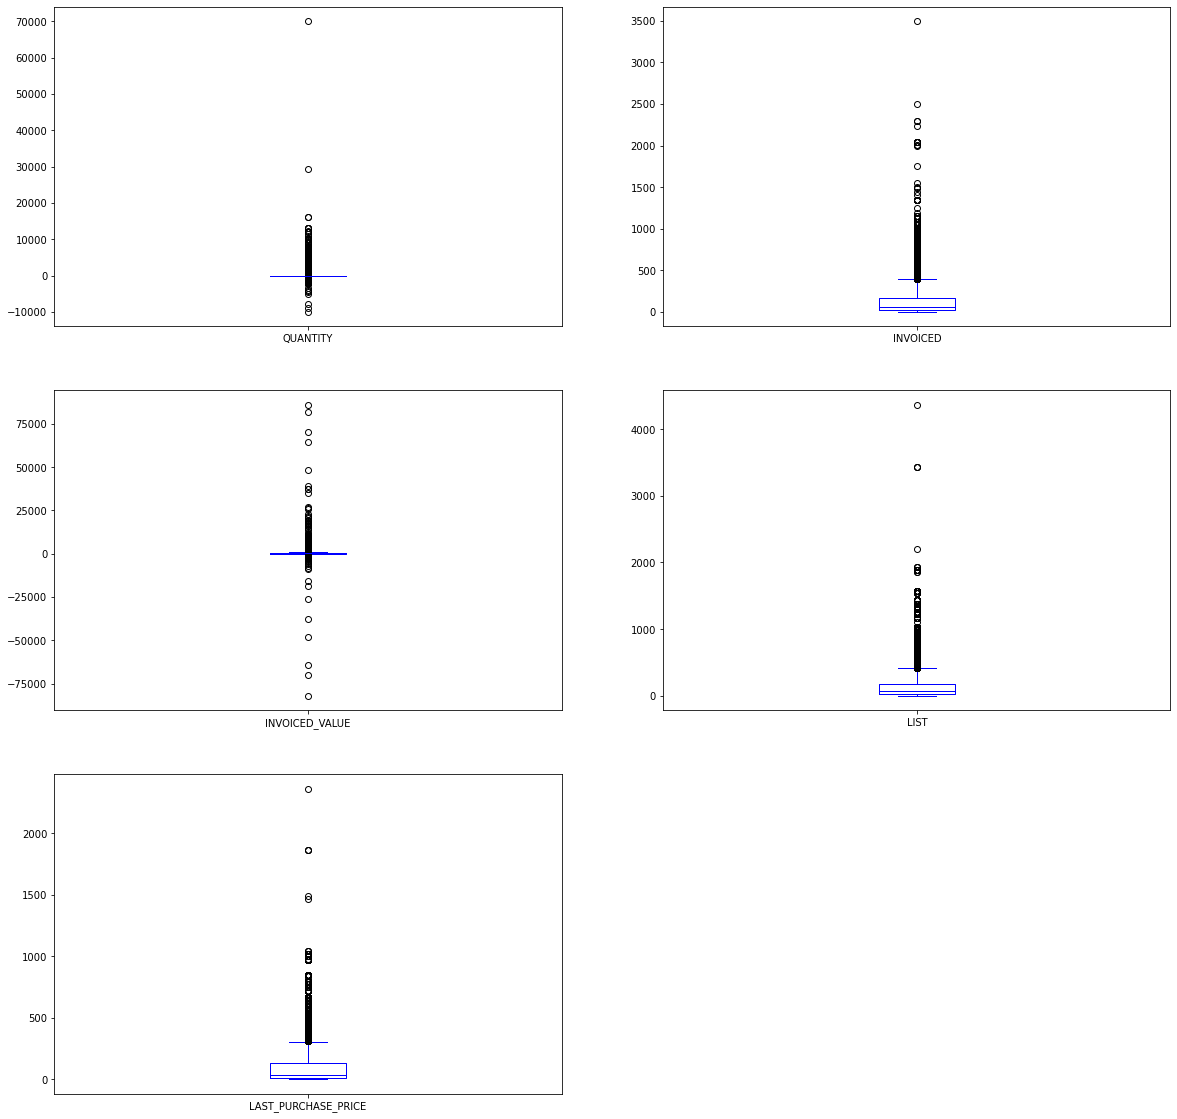

In [8]:
#check for outliers in the dataset
main_data.plot(kind='box', subplots=True, layout=(3,2), sharex=False, sharey=False, figsize=(20,20),color='blue')
plt.show()

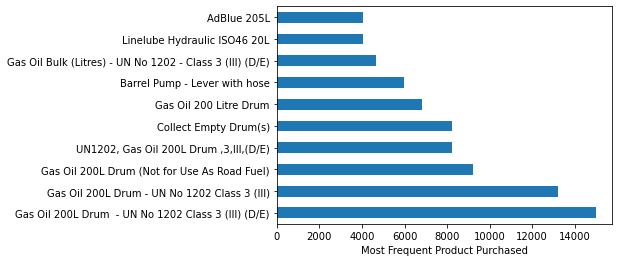

In [9]:
#'DESCRIPTION' EDA for top 10 products purchased
top_10_products = main_data.DESCRIPTION.value_counts()
top_10_products[:10].plot(kind='barh')
plt.xlabel('Most Frequent Product Purchased');

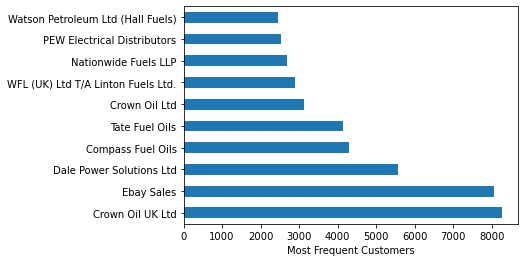

In [10]:
#'NAME' EDA for top 10 most frequent customers
top_10_customers = main_data.NAME.value_counts()
top_10_customers[:10].plot(kind='barh')
plt.xlabel('Most Frequent Customers');

In [11]:
#Industry Category EDA
values = main_data.groupby('category_name').agg('count')['ACCOUNT_REF'].values
relative_values = [(i/sum(values))*100 for i in values]

In [12]:
langs = cbc_customer_data.groupby('category_name').agg('count')['ACCOUNT_REF'].index
students = relative_values
data = [go.Bar(
   x = langs,
   y = students
)]
fig = go.Figure(data=data)
fig

In [13]:
eda_desc = main_data.loc[main_data['DESCRIPTION'] == "Gas Oil 200L Drum  - UN No 1202 Class 3 (III) (D/E)"]


Text(0, 0.5, 'Frequency')

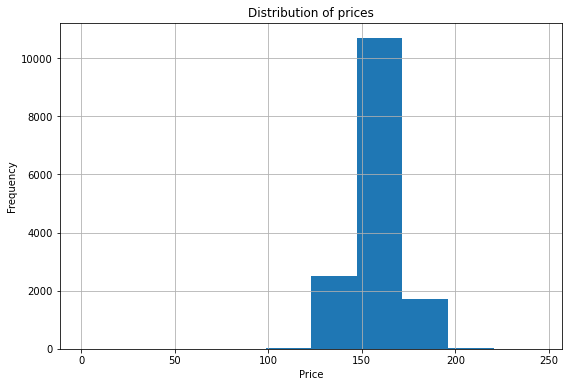

In [14]:
#Price Distribution for Best Selling Product
eda_desc = eda_desc[eda_desc.INVOICED > 0]
eda_desc

MIN, MAX = .01, 10.0
fig, ax = plt.subplots(1, 1, figsize = (9,6))
eda_desc['INVOICED'].hist(bins=10)
plt.xlabel('Price')
plt.title('Distribution of prices')
plt.ylabel('Frequency')

In [15]:
eda_desc["INVOICED"].describe()

count    14968.000000
mean       157.928851
std         12.617961
min          0.800000
25%        150.000000
50%        158.000000
75%        166.000000
max        245.000000
Name: INVOICED, dtype: float64

In [16]:
eda_desc_2 = main_data.loc[main_data['DESCRIPTION'] == "AdBlue 205L"]

Text(0, 0.5, 'Frequency')

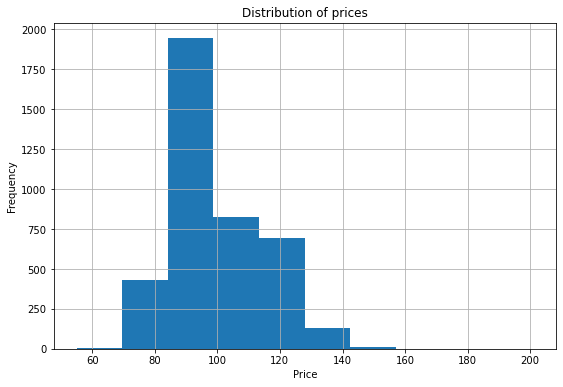

In [17]:
#Price Distribution for Best Selling Product
eda_desc_2 = eda_desc_2[eda_desc_2.INVOICED > 0]
eda_desc_2

MIN, MAX = .01, 10.0
fig, ax = plt.subplots(1, 1, figsize = (9,6))
eda_desc_2['INVOICED'].hist(bins=10)
plt.xlabel('Price')
plt.title('Distribution of prices')
plt.ylabel('Frequency')

In [18]:
eda_desc_2["INVOICED"].describe()

count    4044.000000
mean       99.808724
std        14.618884
min        55.000000
25%        90.000000
50%        95.000000
75%       110.000000
max       200.900000
Name: INVOICED, dtype: float64

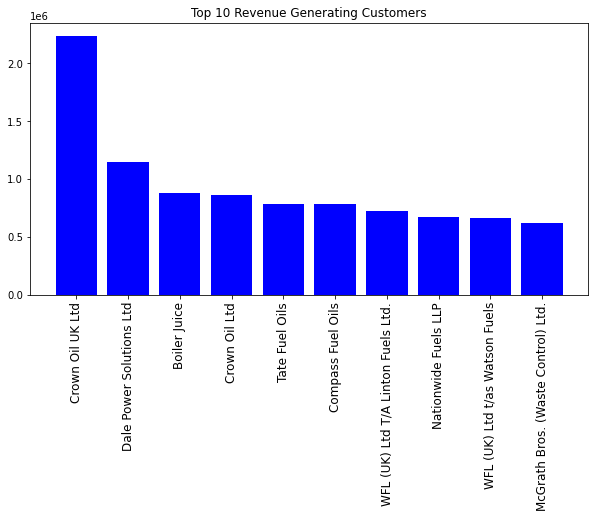

In [19]:
customer_eda = main_data.groupby(['NAME']).INVOICED_VALUE.sum().nlargest(10)
plt.figure(figsize=(10,5))
plt.bar(range(len(customer_eda)), customer_eda.values, align='center', color='b')
plt.xticks(range(len(customer_eda)), customer_eda.index.values, fontsize='large',rotation='vertical')
plt.title('Top 10 Revenue Generating Customers', fontsize=12)
plt.show()

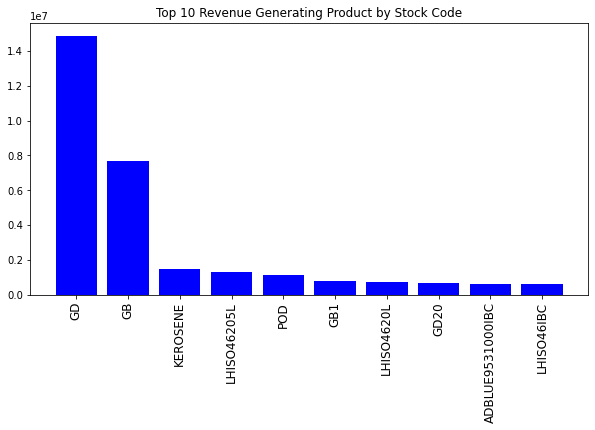

In [20]:
product_eda = main_data.groupby(['STOCK_CODE']).INVOICED_VALUE.sum().nlargest(10)
plt.figure(figsize=(10,5))
plt.bar(range(len(product_eda)), product_eda.values, align='center', color='b')
plt.xticks(range(len(product_eda)), product_eda.index.values, fontsize='large',rotation='vertical')
plt.title('Top 10 Revenue Generating Product by Stock Code', fontsize=12)
plt.show()

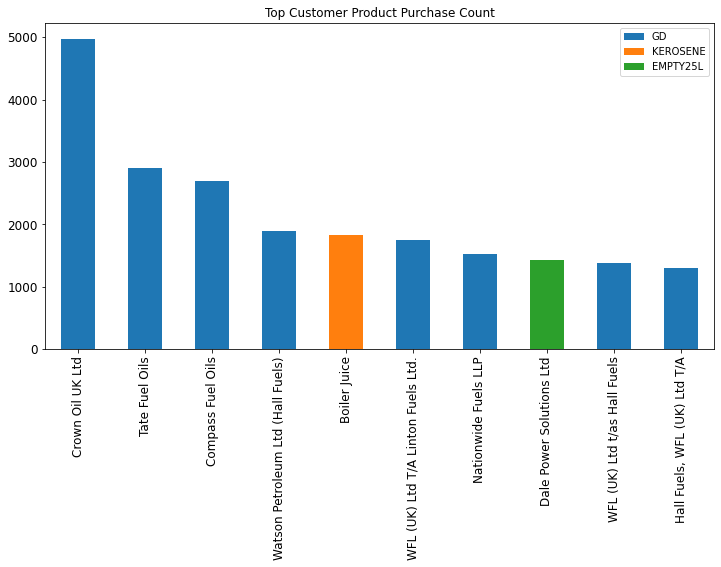

In [21]:
customers_product_eda = main_data.groupby(['NAME']).STOCK_CODE.value_counts().nlargest(10)
customers_product_eda.unstack().plot(kind='bar', stacked=True, figsize=(12,6), fontsize='large')
plt.xticks(range(len(customers_product_eda.unstack())), customers_product_eda.unstack().index.values, fontsize='large')
plt.yticks(fontsize='large')
plt.ylabel(None)
plt.xlabel(None)
plt.title('Top Customer Product Purchase Count', fontsize=12)
plt.legend()
plt.show()

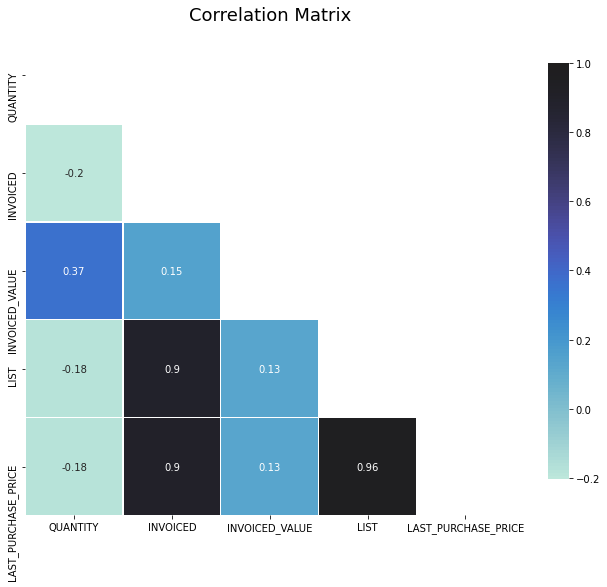

In [22]:
#Check correlation between features  -some variables are highly correlated due to similarities between features, to be adjusted at a later stage
numerical_variables = main_data

mask = np.zeros_like(numerical_variables.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f,ax = plt.subplots(figsize = (12, 9))
plt.title('Correlation Matrix', fontsize=18)

sns.heatmap(numerical_variables.corr(), linewidth=0.30, vmax=1.00, square=True, center=1, annot = numerical_variables.corr(), linecolor='w', mask=mask, cbar_kws={'shrink':0.85})
plt.show()

# Feature Engineering

In [23]:
import datetime
main_data['YEAR'] = main_data['INVOICE_DATE'].apply(lambda x: x.year)
main_data['MONTH'] = main_data['INVOICE_DATE'].apply(lambda x: x.month)
main_data['DAY'] = main_data['INVOICE_DATE'].apply(lambda x: x.day)

In [24]:
#All values should be greater than 0
main_data = main_data[main_data['INVOICED']>0]
main_data = main_data[main_data['INVOICED_VALUE']>0]
main_data = main_data[main_data['LAST_PURCHASE_PRICE']>0]
main_data = main_data[main_data['LIST']>0]

In [25]:
#Create new features 
main_data['TOTAL_COST_PRICE'] = main_data['QUANTITY']*main_data['LAST_PURCHASE_PRICE']
main_data['PROFIT_MARGIN'] = (main_data['INVOICED_VALUE']/main_data['TOTAL_COST_PRICE'])*100

In [26]:
#Detect outliers 3 standard deviations away from the mean

outliers=[]
def detect_outlier(data_1):
    
    threshold=3
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    
    
    for y in data_1:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers

In [27]:
#Find profit margin threshold value
outlier_datapoints = detect_outlier(main_data[main_data['PROFIT_MARGIN']!=np.inf]['PROFIT_MARGIN'])
print("Profit margin threshold: " + str(min(outlier_datapoints)))

Profit margin threshold: 3956.8345323741005


In [28]:
#Remove outliers
main_data = main_data[main_data['PROFIT_MARGIN']<min(outlier_datapoints)]

In [29]:
#Generate Top 50% of products, which is = to 90% of total revenue (instructed by manager- Peter)
top_selling_stocks = main_data.groupby('DESCRIPTION')[['INVOICED_VALUE']].sum()
profits_90 = top_selling_stocks.sum() * 0.9
top_selling_stocks_sorted = top_selling_stocks.sort_values('INVOICED_VALUE', ascending=False)
top_selling_stocks_sorted['CUMSUM'] = top_selling_stocks_sorted['INVOICED_VALUE'].cumsum()
top_selling_list = top_selling_stocks_sorted[top_selling_stocks_sorted['CUMSUM'] < profits_90[0]].index.tolist()

main_top90 = main_data[main_data['DESCRIPTION'].isin(top_selling_list)]

In [30]:
main_top90

INVOICE_DATE ACCOUNT_REF                        NAME  QUANTITY  \
2        2013-01-17      TRIDAN                  Tridan Ltd       1.0   
3        2013-02-15      TRIDAN                  Tridan Ltd       1.0   
4        2013-03-07      TRIDAN                  Tridan Ltd       1.0   
5        2013-03-22      TRIDAN                  Tridan Ltd       1.0   
6        2013-04-24      TRIDAN                  Tridan Ltd       1.0   
...             ...         ...                         ...       ...   
219247   2021-04-09    DALEPOWE    Dale Power Solutions Ltd      13.0   
219248   2021-04-09    EVO94405          Evoke Supplies Ltd       4.0   
219249   2021-04-12    MEG21091  Mega Foods LTD ( CC ACCT )       1.0   
219250   2021-04-14    CROWNOIL               Crown Oil Ltd       1.0   
219251   2021-04-15    DALEPOWE    Dale Power Solutions Ltd      20.0   

       STOCK_CODE                             DESCRIPTION  INVOICED  \
2           22736  LineCut Soluble EP 205L (ECO-COOL XTL)   1076.25   
3           22736  LineCut Soluble EP 205L (ECO-COOL XTL)   1076.25   
4           22736  LineCut Soluble EP 205L (ECO-COOL XTL)   1076.25   
5           22736  LineCut Soluble EP 205L (ECO-COOL XTL)   1076.25   
6           22736  LineCut Soluble EP 205L (ECO-COOL XTL)   1076.25   
...           ...                                     ...       ...   
219247      WATER                De-mineralised Water 25L     18.75   
219248      WATER                De-mineralised Water 25L     11.00   
219249      WATER                De-mineralised Water 25L     11.00   
219250      WATER                De-mineralised Water 25L     18.00   
219251      WATER                De-mineralised Water 25L     18.75   

        INVOICED_VALUE     LIST  LAST_PURCHASE_PRICE        STATUS_TEXT  \
2              1076.25  1312.41                795.4    Closed - UNUSED   
3              1076.25  1312.41                795.4    Closed - UNUSED   
4              1076.25  1312.41                795.4    Closed - UNUSED   
5              1076.25  1312.41                795.4    Closed - UNUSED   
6              1076.25  1312.41                795.4    Closed - UNUSED   
...                ...      ...                  ...                ...   
219247          243.75    13.15                  4.0               Open   
219248           44.00    13.15                  4.0  Direct Debit 30th   
219249           11.00    13.15                  4.0   COLLECT CHQ/CASH   
219250           18.00    13.15                  4.0               Open   
219251          375.00    13.15                  4.0               Open   

                       category_name  YEAR  MONTH  DAY  TOTAL_COST_PRICE  \
2       Manufacturing and Industrial  2013      1   17             795.4   
3       Manufacturing and Industrial  2013      2   15             795.4   
4       Manufacturing and Industrial  2013      3    7             795.4   
5       Manufacturing and Industrial  2013      3   22             795.4   
6       Manufacturing and Industrial  2013      4   24             795.4   
...                              ...   ...    ...  ...               ...   
219247              Power Generation  2021      4    9              52.0   
219248                         Other  2021      4    9              16.0   
219249                 Food Industry  2021      4   12               4.0   
219250               3rd. Party Fuel  2021      4   14               4.0   
219251              Power Generation  2021      4   15              80.0   

        PROFIT_MARGIN  
2          135.309278  
3          135.309278  
4          135.309278  
5          135.309278  
6          135.309278  
...               ...  
219247     468.750000  
219248     275.000000  
219249     275.000000  
219250     450.000000  
219251     468.750000  

[158419 rows x 17 columns]

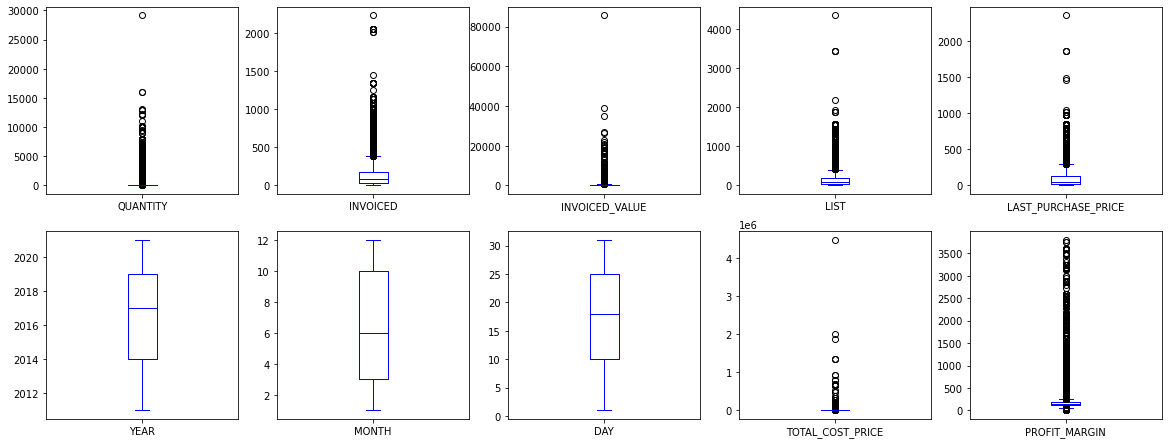

In [31]:
main_data.plot(kind='box', subplots=True, layout=(5,5), sharex=False, sharey=False, figsize=(20,20),color='blue')
plt.show()

Outliers still exist however, this is due to the inconsistent pricing structure of Online Lubricants

In [32]:
main_data.head()

INVOICE_DATE ACCOUNT_REF                           NAME  QUANTITY  \
0   2013-11-28    AMSTONTR  Anston Transport Services Ltd       1.0   
1   2013-11-29    DHUGGETT           David Huggett MF Ltd       1.0   
2   2013-01-17      TRIDAN                     Tridan Ltd       1.0   
3   2013-02-15      TRIDAN                     Tridan Ltd       1.0   
4   2013-03-07      TRIDAN                     Tridan Ltd       1.0   

  STOCK_CODE                             DESCRIPTION  INVOICED  \
0       2174      Petronas Urania Ecotech 10w40 200l    335.00   
1       2174      Petronas Urania Ecotech 10w40 200l    420.00   
2      22736  LineCut Soluble EP 205L (ECO-COOL XTL)   1076.25   
3      22736  LineCut Soluble EP 205L (ECO-COOL XTL)   1076.25   
4      22736  LineCut Soluble EP 205L (ECO-COOL XTL)   1076.25   

   INVOICED_VALUE     LIST  LAST_PURCHASE_PRICE      STATUS_TEXT  \
0          335.00   528.00                320.0  Closed - UNUSED   
1          420.00   528.00                320.0             Open   
2         1076.25  1312.41                795.4  Closed - UNUSED   
3         1076.25  1312.41                795.4  Closed - UNUSED   
4         1076.25  1312.41                795.4  Closed - UNUSED   

                     category_name  YEAR  MONTH  DAY  TOTAL_COST_PRICE  \
0  Commercial Workshop / Transport  2013     11   28             320.0   
1                         Reseller  2013     11   29             320.0   
2     Manufacturing and Industrial  2013      1   17             795.4   
3     Manufacturing and Industrial  2013      2   15             795.4   
4     Manufacturing and Industrial  2013      3    7             795.4   

   PROFIT_MARGIN  
0     104.687500  
1     131.250000  
2     135.309278  
3     135.309278  
4     135.309278

In [33]:
adblue = main_data[main_data['DESCRIPTION']=='AdBlue 205L']


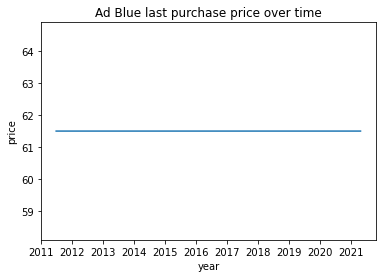

In [34]:
plt.plot(adblue['INVOICE_DATE'],adblue['LAST_PURCHASE_PRICE'])
plt.title('Ad Blue last purchase price over time')
plt.xlabel('year')
plt.ylabel('price')
plt.show()

In [35]:
gl = main_data[main_data['DESCRIPTION']=='Gas Oil 200L Drum  - UN No 1202 Class 3 (III) (D/E)']
gl.head(50)

INVOICE_DATE ACCOUNT_REF  \
156071   2017-03-15       HALLS   
156072   2017-03-15       HALLS   
156074   2017-03-15    JOHNSTOI   
156077   2017-03-15    OIL4WALE   
156084   2017-03-16    ABBEYPGS   
156089   2017-03-16    CASTLEVI   
156090   2017-03-16       CEDAR   
156092   2017-03-16    CNC(BUIL   
156095   2017-03-16    COMPASSF   
156102   2017-03-16       HALLS   
156103   2017-03-16       HALLS   
156120   2017-03-16    NIEUIVEZ   
156122   2017-03-16    OPTICREA   
156123   2017-03-16    POWER200   
156125   2017-03-16       SEHMI   
156140   2017-03-17    AMBASSAD   
156141   2017-03-17    ARTLONDO   
156142   2017-03-17        CASH   
156143   2017-03-17    CHALLENG   
156144   2017-03-17    GEOSTRUC   
156145   2017-03-17       HALLS   
156146   2017-03-17       HALLS   
156147   2017-03-17       HALLS   
156148   2017-03-17       HALLS   
156149   2017-03-17    LOGANCON   
156150   2017-03-17       SHACA   
156151   2017-03-17    SOUTHER1   
156152   2017-03-17    UNI70663   
156153   2017-03-17      WESSEX   
156154   2017-03-20    ABBEYPGS   
156155   2017-03-20    ANDYSKIL   
156156   2017-03-20    CASTLEOA   
156157   2017-03-20    COMPASSF   
156158   2017-03-20    CONCEPTE   
156159   2017-03-20    CROWNOIL   
156160   2017-03-20    DALEPOWE   
156161   2017-03-20     SAIMAXX   
156162   2017-03-20     THAMESN   
156163   2017-03-21    AEMDEMOL   
156164   2017-03-21    ANDERSON   
156165   2017-03-21     ARCBUIL   
156166   2017-03-21     ARCBUIL   
156167   2017-03-21    BONNIESO   
156168   2017-03-21    CHU77267   
156172   2017-03-21     EASTLCM   
156173   2017-03-21       HALLS   
156174   2017-03-21       HALLS   
156175   2017-03-21       HALLS   
156176   2017-03-21    IDJ57123   
156177   2017-03-21    LLOYDAND   

                                                  NAME  QUANTITY STOCK_CODE  \
156071                    Hall Fuels, WFL (UK) Ltd T/A       3.0         GD   
156072                    Hall Fuels, WFL (UK) Ltd T/A       2.0         GD   
156074                               Johnston Oils Ltd       1.0         GD   
156077                                    Oil 4 GB Ltd       1.0         GD   
156084               Abbey Pynford GEO- Structures Ltd       1.0         GD   
156089                         Castle View Development       2.0         GD   
156090      One Stop  Builders  Merchant (Enfield) Ltd       1.0         GD   
156092                     CNC (Building Supplies) Ltd       1.0         GD   
156095                               Compass Fuel Oils       2.0         GD   
156102                    Hall Fuels, WFL (UK) Ltd T/A       1.0         GD   
156103                    Hall Fuels, WFL (UK) Ltd T/A       1.0         GD   
156120                          NIEUIVE ZORG (CC ACCT)       1.0         GD   
156122                                 Opticrelam  Ltd       2.0         GD   
156123                              Power 2000.com Ltd       1.0         GD   
156125                             Sehmi and Sons    *       2.0         GD   
156140                Windsor Engineering ( Hull ) Ltd       1.0         GD   
156141                                             Art       1.0         GD   
156142                                            CASH       1.0         GD   
156143                           Challenge Fencing Ltd       2.0         GD   
156144                               Geostructures Ltd       1.0         GD   
156145                    Hall Fuels, WFL (UK) Ltd T/A       2.0         GD   
156146                    Hall Fuels, WFL (UK) Ltd T/A       2.0         GD   
156147                    Hall Fuels, WFL (UK) Ltd T/A       1.0         GD   
156148                    Hall Fuels, WFL (UK) Ltd T/A       2.0         GD   
156149                          Logan Construction Ltd       2.0         GD   
156150                          Shaca Construction Ltd       1.0         GD   
156151                            Southern Farmers Ltd       4.0         GD   
156152   

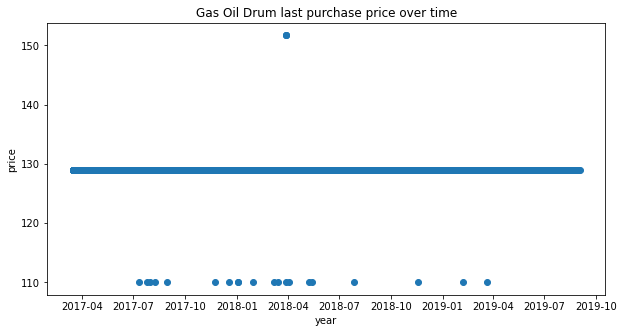

In [36]:
fig = plt.figure(figsize=(10, 5))
plt.scatter(gl['INVOICE_DATE'],gl['LAST_PURCHASE_PRICE'])
plt.title('Gas Oil Drum last purchase price over time')
plt.xlabel('year')
plt.ylabel('price')
plt.show()

In [37]:
gl[gl['LAST_PURCHASE_PRICE']>149]

INVOICE_DATE ACCOUNT_REF                          NAME  QUANTITY  \
179567   2018-03-29       HALLS  WFL (UK) Ltd t/as Hall Fuels       1.0   
179569   2018-03-29       HALLS  WFL (UK) Ltd t/as Hall Fuels       2.0   
179571   2018-03-29    UKSGROUP                     UKS Group       1.0   

       STOCK_CODE                                        DESCRIPTION  \
179567        GD1  Gas Oil 200L Drum  - UN No 1202 Class 3 (III) ...   
179569        GD1  Gas Oil 200L Drum  - UN No 1202 Class 3 (III) ...   
179571        GD1  Gas Oil 200L Drum  - UN No 1202 Class 3 (III) ...   

        INVOICED  INVOICED_VALUE   LIST  LAST_PURCHASE_PRICE  \
179567     184.0           184.0  184.5                151.7   
179569     170.0           340.0  184.5                151.7   
179571     180.0           180.0  184.5                151.7   

              STATUS_TEXT    category_name  YEAR  MONTH  DAY  \
179567  Direct Debit 30th  3rd. Party Fuel  2018      3   29   
179569  Direct Debit 30th  3rd. Party Fuel  2018      3   29   
179571               Open            Other  2018      3   29   

        TOTAL_COST_PRICE  PROFIT_MARGIN  
179567             151.7     121.292024  
179569             303.4     112.063283  
179571             151.7     118.655241

In [38]:
gl[gl['INVOICE_DATE']=='2018-03-29'].LAST_PURCHASE_PRICE.min()

110.0

In [39]:
gl[gl['INVOICE_DATE']=='2018-03-29'].LAST_PURCHASE_PRICE.max()

151.7

## Moving Average

In [40]:
import talib

In [41]:
unique_descriptions = main_top90.DESCRIPTION.unique().tolist() #moving average for individual product prices
unique_industries = main_top90.category_name.unique().tolist() #moving average for industry specific prices
dfs = []
for d in unique_descriptions:
    for i in unique_industries:
        tmp_df = main_top90[(main_top90.DESCRIPTION == d) & (main_top90.category_name == i)]
        tmp_df = tmp_df.sort_values(by='INVOICE_DATE')
        tmp_df['moving_average_7'] = tmp_df.INVOICED.rolling(7, min_periods=1).mean() #compute on last 7 transactions for all products
        tmp_df['moving_average_30'] = tmp_df.INVOICED.rolling(30, min_periods=1).mean() #compute on last 30 transactions for all products
    
        dfs.append(tmp_df)

In [42]:
main_top90_sorted = pd.concat(dfs)

In [43]:
main_top90_sorted

INVOICE_DATE ACCOUNT_REF                 NAME  QUANTITY STOCK_CODE  \
2        2013-01-17      TRIDAN           Tridan Ltd       1.0      22736   
3        2013-02-15      TRIDAN           Tridan Ltd       1.0      22736   
4        2013-03-07      TRIDAN           Tridan Ltd       1.0      22736   
5        2013-03-22      TRIDAN           Tridan Ltd       1.0      22736   
6        2013-04-24      TRIDAN           Tridan Ltd       1.0      22736   
...             ...         ...                  ...       ...        ...   
218930   2019-07-04    LONDONCT  London City Airport       8.0      WATER   
218767   2018-09-20    FORESTFR       Forest Freight       1.0      WATER   
218788   2018-11-15    FORESTFR       Forest Freight       1.0      WATER   
218983   2019-09-16    FORESTFR       Forest Freight       1.0      WATER   
219187   2020-11-27    FORESTFR   Forest Freight Ltd       1.0      WATER   

                                   DESCRIPTION  INVOICED  INVOICED_VALUE  \
2       LineCut Soluble EP 205L (ECO-COOL XTL)   1076.25         1076.25   
3       LineCut Soluble EP 205L (ECO-COOL XTL)   1076.25         1076.25   
4       LineCut Soluble EP 205L (ECO-COOL XTL)   1076.25         1076.25   
5       LineCut Soluble EP 205L (ECO-COOL XTL)   1076.25         1076.25   
6       LineCut Soluble EP 205L (ECO-COOL XTL)   1076.25         1076.25   
...                                        ...       ...             ...   
218930                De-mineralised Water 25L      8.32           66.56   
218767                De-mineralised Water 25L     13.15           13.15   
218788                De-mineralised Water 25L     13.15           13.15   
218983                De-mineralised Water 25L     13.15           13.15   
219187                De-mineralised Water 25L     13.15           13.15   

           LIST  LAST_PURCHASE_PRICE      STATUS_TEXT  \
2       1312.41                795.4  Closed - UNUSED   
3       1312.41                795.4  Closed - UNUSED   
4       1312.41                795.4  Closed - UNUSED   
5       1312.41                795.4  Closed - UNUSED   
6       1312.41                795.4  Closed - UNUSED   
...         ...                  ...              ...   
218930    13.15                  4.0  Closed - UNUSED   
218767    13.15                  4.0             Open   
218788    13.15                  4.0             Open   
218983    13.15                  4.0             Open   
219187    13.15                  4.0             Open   

                       category_name  YEAR  MONTH  DAY  TOTAL_COST_PRICE  \
2       Manufacturing and Industrial  2013      1   17             795.4   
3       Manufacturing and Industrial  2013      2   15             795.4   
4       Manufacturing and Industrial  2013      3    7             795.4   
5       Manufacturing and Industrial  2013      3   22             795.4   
6       Manufacturing and Industrial  2013      4   24             795.4   
...                              ...   ...    ...  ...               ...   
218930   Facility Provider / Utility  2019      7    4              32.0   
218767       Haulage and Warehousing  2018      9   20               4.0   
218788       Haulage and Warehousing  2018     11   15               4.0   
218983       Haulage and Warehousing  2019      9   16               4.0   
219187       Haulage and Warehousing  2020     11   27               4.0   

        PROFIT_MARGIN  moving_average_7  moving_average_30  
2          135.309278           1076.25            1076.25  
3          135.309278           1076.25            1076.25  
4          135.309278           1076.25            1076.25  
5          135.309278           1076.25            1076.25  
6          135.309278           1076.25            1076.25  
...               ...               ...                ...  
218930     208.000000              8.32               8.32  
218767     328.750000             13.15              13.15  
218788     328.750000 

In [44]:
main_top90_sorted[['INVOICE_DATE', 'DESCRIPTION', 'category_name', 'INVOICED', 'moving_average_30', 'moving_average_7']].to_csv('industry_average.csv')

In [45]:
#Test by computing moving average for Best Selling Product
gasoil_viz = main_top90_sorted[main_top90_sorted.DESCRIPTION=='Gas Oil 200L Drum  - UN No 1202 Class 3 (III) (D/E)']

In [46]:
gasoil_viz

INVOICE_DATE ACCOUNT_REF                                 NAME  \
156143   2017-03-17    CHALLENG                Challenge Fencing Ltd   
156158   2017-03-20    CONCEPTE  Concept Engineering Consultants Ltd   
156198   2017-03-22    CONCEPTE  Concept Engineering Consultants Ltd   
156238   2017-03-24    AVGROUPL                         AV Group Ltd   
156282   2017-03-27    LED65595      Leda Form Work UK Ltd (CC ACCT)   
...             ...         ...                                  ...   
167442   2019-01-31    OAKHILLC                     Oak Hill College   
169219   2019-04-30         NRA           National Rifle Association   
160499   2017-12-22    PRE09972                           Prestopets   
167446   2019-01-31    PRE09972                           Prestopets   
169434   2019-05-14    PRE09972                           Prestopets   

        QUANTITY STOCK_CODE  \
156143       2.0         GD   
156158       1.0         GD   
156198       1.0         GD   
156238       1.0         GD   
156282       1.0         GD   
...          ...        ...   
167442       4.0         GD   
169219       2.0         GD   
160499       1.0         GD   
167446       1.0         GD   
169434       1.0         GD   

                                              DESCRIPTION  INVOICED  \
156143  Gas Oil 200L Drum  - UN No 1202 Class 3 (III) ...     150.0   
156158  Gas Oil 200L Drum  - UN No 1202 Class 3 (III) ...     144.0   
156198  Gas Oil 200L Drum  - UN No 1202 Class 3 (III) ...     144.0   
156238  Gas Oil 200L Drum  - UN No 1202 Class 3 (III) ...     146.0   
156282  Gas Oil 200L Drum  - UN No 1202 Class 3 (III) ...     140.0   
...                                                   ...       ...   
167442  Gas Oil 200L Drum  - UN No 1202 Class 3 (III) ...     165.0   
169219  Gas Oil 200L Drum  - UN No 1202 Class 3 (III) ...     185.0   
160499  Gas Oil 200L Drum  - UN No 1202 Class 3 (III) ...     140.0   
167446  Gas Oil 200L Drum  - UN No 1202 Class 3 (III) ...     160.0   
169434  Gas Oil 200L Drum  - UN No 1202 Class 3 (III) ...     160.0   

        INVOICED_VALUE   LIST  LAST_PURCHASE_PRICE        STATUS_TEXT  \
156143           300.0  180.0                129.0               Open   
156158           144.0  180.0                129.0  Direct debit 20th   
156198           144.0  180.0                129.0  Direct debit 20th   
156238           146.0  180.0                129.0               Open   
156282           140.0  180.0                129.0    Closed - UNUSED   
...                ...    ...                  ...                ...   
167442           660.0  180.0                129.0               Open   
169219           370.0  180.0                129.0               Open   
160499           140.0  180.0                129.0  Direct debit 20th   
167446           160.0  180.0                129.0  Direct debit 20th   
169434           160.0  180.0                129.0  Direct debit 20th   

                       category_name  YEAR  MONTH  DAY  TOTAL_COST_PRICE  \
156143  Manufacturing and Industrial  2017      3   17             258.0   
156158  Manufacturing and Industrial  2017      3   20             129.0   
156198  Manufacturing and Industrial  2017      3   22             129.0   
156238  Manufacturing and Industrial  2017      3   24             129.0   
156282  Manufacturing and Industrial  2017      3   27             129.0   
...                              ...   ...    ...  ...               ...   
167442               Local Authority  2019      1   31             516.0   
169219               Local Authority  2019      4   30             258.0   
160499    Ornamental Fish Wholesaler  2017     12   22             129.0   
167446    Ornamental Fish Wholesaler  2019      1   31             129.0   
169434    Ornamental Fish Wholesaler  2019      5   14             129.0   

        PROFIT_MARGIN  moving_average_7  moving_average_30  
156143     116.279070        150.000000         150.000000  
1561

In [47]:
total_invoiced = gasoil_viz['INVOICED'].sum()
print(total_invoiced)

2357336.2399999998


In [48]:
total_moving_average_7 = gasoil_viz['moving_average_7'].sum()
total_moving_average_7

2356707.7847619047

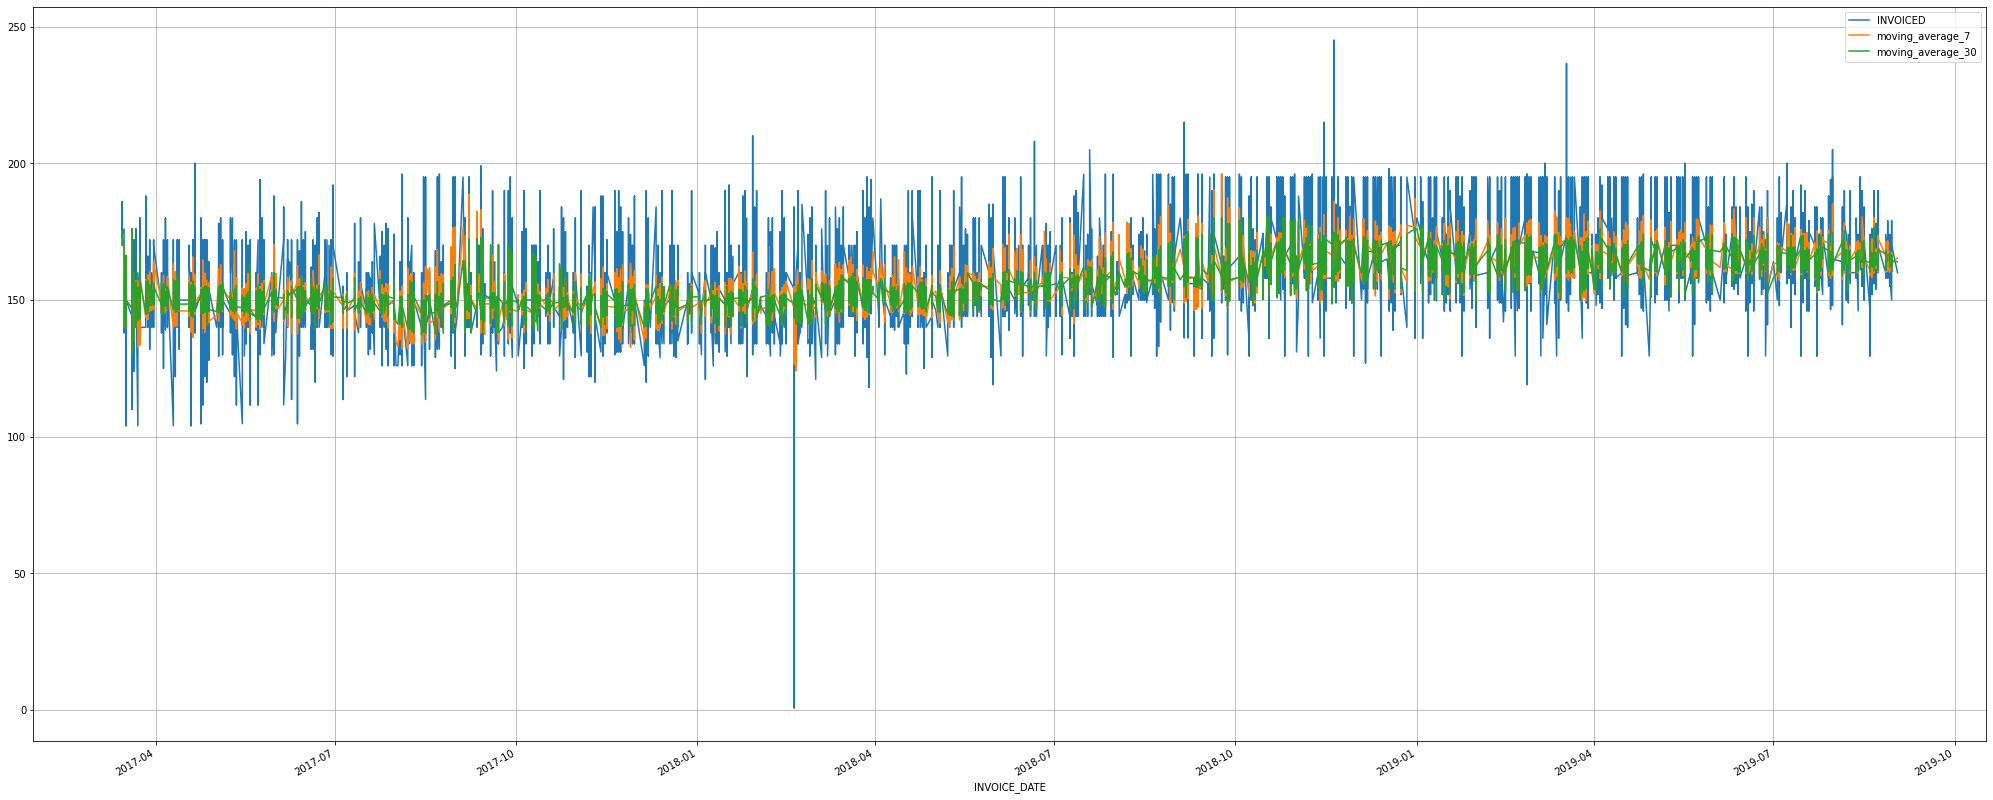

In [49]:
gasoil_viz.plot(x="INVOICE_DATE", y=["INVOICED","moving_average_7","moving_average_30"], figsize = (35,15), grid=True)

In [50]:
adblue_viz = main_top90_sorted[main_top90_sorted.DESCRIPTION=='AdBlue 205L']

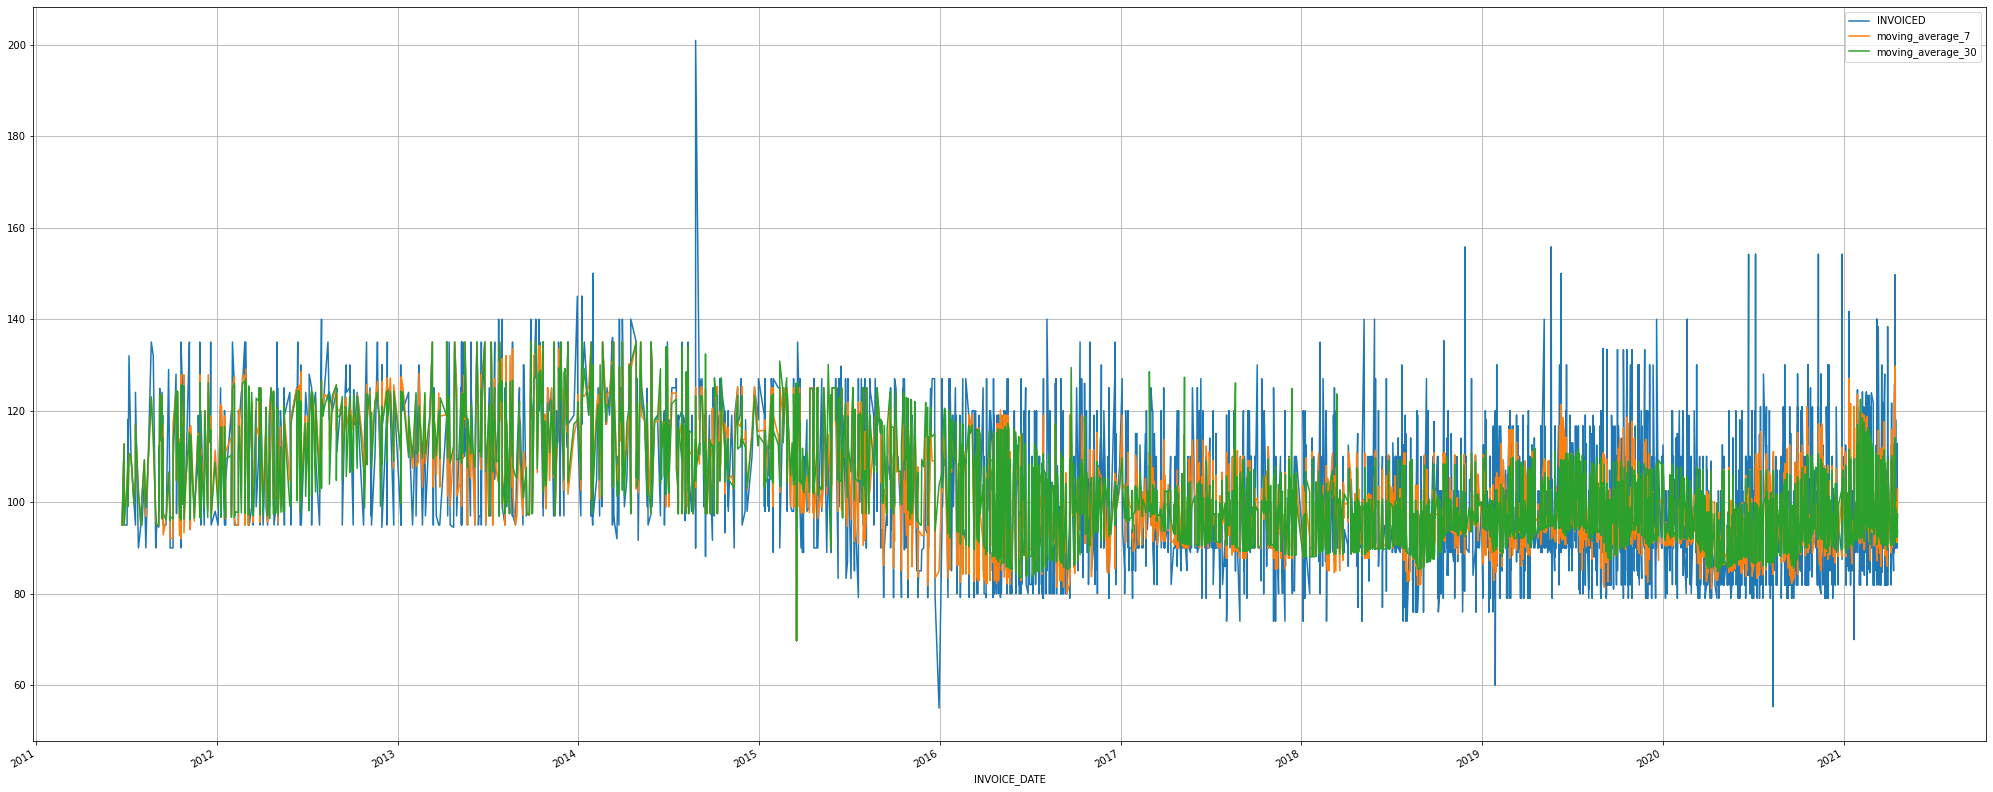

In [51]:
adblue_viz.plot(x="INVOICE_DATE", y=["INVOICED","moving_average_7","moving_average_30"], figsize = (35,15), grid=True)

## One Hot Encoding

In [52]:
from numpy import asarray
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

In [53]:
#Change dataframe name
main = main_top90

In [54]:
main = main.reset_index()

In [55]:
#One hot encoding on category_name
encoder = OneHotEncoder(sparse=False)
industry_onehot = encoder.fit_transform(asarray(main['category_name']).reshape(-1, 1))

In [56]:
#One hot encoding on DESCRIPTION
encoder = OneHotEncoder(sparse=False)
description_onehot = encoder.fit_transform(asarray(main['DESCRIPTION']).reshape(-1, 1))

In [57]:
description_onehot.shape

(158419, 304)

In [58]:
description_header = []
for i in range(0,304):
    name = 'description_'+str(i+1)
    description_header.append(name)

In [59]:
industry_header = []
for i in range(0,18):
    name = 'industry_'+str(i+1)
    industry_header.append(name)

In [60]:
industry_df = pd.DataFrame(industry_onehot, columns=industry_header)

In [61]:
industry_df_full = pd.concat([main['category_name'], industry_df], axis=1)
industry_df_full_tmp = industry_df_full.groupby('category_name').sum()
industry_df_ref = pd.concat([pd.Series(pd.Series(industry_df_full_tmp.ne(0).idxmax().index).values), pd.Series(industry_df_full_tmp.ne(0).idxmax().values)], axis=1)

In [62]:
industry_df_ref.to_csv('industry_mapping.csv')

In [63]:
description_df = pd.DataFrame(description_onehot, columns=description_header)

In [64]:
description_df.head()

description_1  description_2  description_3  description_4  description_5  \
0            0.0            0.0            0.0            0.0            0.0   
1            0.0            0.0            0.0            0.0            0.0   
2            0.0            0.0            0.0            0.0            0.0   
3            0.0            0.0            0.0            0.0            0.0   
4            0.0            0.0            0.0            0.0            0.0   

   description_6  description_7  description_8  description_9  description_10  \
0            0.0            0.0            0.0            0.0             0.0   
1            0.0            0.0            0.0            0.0             0.0   
2            0.0            0.0            0.0            0.0             0.0   
3            0.0            0.0            0.0            0.0             0.0   
4            0.0            0.0            0.0            0.0             0.0   

   ...  description_295  description_296  description_297  description_298  \
0  ...              0.0              0.0              0.0              0.0   
1  ...              0.0              0.0              0.0              0.0   
2  ...              0.0              0.0              0.0              0.0   
3  ...              0.0              0.0              0.0              0.0   
4  ...              0.0              0.0              0.0              0.0   

   description_299  description_300  description_301  description_302  \
0              0.0              0.0              0.0              0.0   
1              0.0              0.0              0.0              0.0   
2              0.0              0.0              0.0              0.0   
3              0.0              0.0              0.0              0.0   
4              0.0              0.0              0.0              0.0   

   description_303  description_304  
0              0.0              0.0  
1              0.0              0.0  
2              0.0              0.0  
3              0.0              0.0  
4              0.0              0.0  

[5 rows x 304 columns]

In [65]:
description_df_full = pd.concat([main['DESCRIPTION'], description_df], axis=1)
description_df_full_tmp = description_df_full.groupby('DESCRIPTION').sum()
description_df_ref = pd.concat([pd.Series(pd.Series(description_df_full_tmp.ne(0).idxmax().index).values), pd.Series(description_df_full_tmp.ne(0).idxmax().values)], axis=1)

In [66]:
description_df_ref.to_csv('description_mapping.csv')

In [67]:
description_df_ref.head()

0                                1
0  description_1          (DD) Adblue Bulk Litres
1  description_2      ATF D3M 205L - Petro Canada
2  description_3  AdBlue 1000L AD950 / AD953 Dual
3  description_4        AdBlue 1000L AD950 in IBC
4  description_5              AdBlue 1000L in IBC

In [68]:
len(industry_df), len(description_df)

(158419, 158419)

In [69]:
#Apply ordinal encoding to YEAR, MONTH and DAY categorical variables
ordinal_encoder = OrdinalEncoder()
year_onehot = encoder.fit_transform(asarray(main['YEAR']).reshape(-1, 1))
month_onehot = encoder.fit_transform(asarray(main['MONTH']).reshape(-1, 1))
day_onehot = encoder.fit_transform(asarray(main['DAY']).reshape(-1, 1))

In [70]:
year_header = []
for i in range(0,11):
    name = 'year_'+str(i+1)
    year_header.append(name)

month_header = []
for i in range(0,12):
    name = 'month_'+str(i+1)
    month_header.append(name)
    
day_header = []
for i in range(0,31):
    name = 'day_'+str(i+1)
    day_header.append(name)

In [71]:
year_df = pd.DataFrame(year_onehot, columns=year_header)
month_df = pd.DataFrame(month_onehot, columns=month_header)
day_df = pd.DataFrame(day_onehot, columns=day_header)

In [72]:
year_df_full = pd.concat([main['YEAR'], year_df], axis=1)
year_df_full_tmp = year_df_full.groupby('YEAR').sum()
year_df_ref = pd.concat([pd.Series(pd.Series(year_df_full_tmp.ne(0).idxmax().index).values), pd.Series(year_df_full_tmp.ne(0).idxmax().values)], axis=1)

In [73]:
month_df_full = pd.concat([main['MONTH'], month_df], axis=1)
month_df_full_tmp = month_df_full.groupby('MONTH').sum()
month_df_ref = pd.concat([pd.Series(pd.Series(month_df_full_tmp.ne(0).idxmax().index).values), pd.Series(month_df_full_tmp.ne(0).idxmax().values)], axis=1)

In [74]:
day_df_full = pd.concat([main['DAY'], day_df], axis=1)
day_df_full_tmp = day_df_full.groupby('DAY').sum()
day_df_ref = pd.concat([pd.Series(pd.Series(day_df_full_tmp.ne(0).idxmax().index).values), pd.Series(day_df_full_tmp.ne(0).idxmax().values)], axis=1)

In [75]:
year_df_ref.to_csv('year_mapping.csv')
month_df_ref.to_csv('month_mapping.csv')
day_df_ref.to_csv('day_mapping.csv')

In [76]:
final = main[['QUANTITY', 'INVOICED', 'LAST_PURCHASE_PRICE', 'DESCRIPTION', 'INVOICE_DATE']]

In [77]:
data = pd.concat([final, industry_df, description_df, year_df, month_df, day_df], axis=1)

In [78]:
data.head()

QUANTITY  INVOICED  LAST_PURCHASE_PRICE  \
0       1.0   1076.25                795.4   
1       1.0   1076.25                795.4   
2       1.0   1076.25                795.4   
3       1.0   1076.25                795.4   
4       1.0   1076.25                795.4   

                              DESCRIPTION INVOICE_DATE  industry_1  \
0  LineCut Soluble EP 205L (ECO-COOL XTL)   2013-01-17         0.0   
1  LineCut Soluble EP 205L (ECO-COOL XTL)   2013-02-15         0.0   
2  LineCut Soluble EP 205L (ECO-COOL XTL)   2013-03-07         0.0   
3  LineCut Soluble EP 205L (ECO-COOL XTL)   2013-03-22         0.0   
4  LineCut Soluble EP 205L (ECO-COOL XTL)   2013-04-24         0.0   

   industry_2  industry_3  industry_4  industry_5  ...  day_22  day_23  \
0         0.0         0.0         0.0         0.0  ...     0.0     0.0   
1         0.0         0.0         0.0         0.0  ...     0.0     0.0   
2         0.0         0.0         0.0         0.0  ...     0.0     0.0   
3         0.0         0.0         0.0         0.0  ...     1.0     0.0   
4         0.0         0.0         0.0         0.0  ...     0.0     0.0   

   day_24  day_25  day_26  day_27  day_28  day_29  day_30  day_31  
0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
1     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
2     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
3     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
4     1.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  

[5 rows x 381 columns]

# Modelling

In [79]:
# Import all required libraries
import sklearn.metrics as metrics
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn import model_selection
from sklearn.metrics import accuracy_score, log_loss
import time
from sklearn.model_selection import cross_val_score
from  sklearn.model_selection import GridSearchCV
import sklearn.metrics as sm
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.svm import SVR
from sklearn. linear_model import Lasso
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn. linear_model import Ridge
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
from collections import Counter
np.set_printoptions(suppress=True)
import pickle

In [80]:
x = data.drop('INVOICED', axis=1)
y = data['INVOICED']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [81]:
df_test_visuals=X_test[['DESCRIPTION', 'INVOICE_DATE']]

In [82]:
X_train = X_train.drop('DESCRIPTION', axis=1)
X_test =  X_test.drop('DESCRIPTION', axis=1)
X_train = X_train.drop('INVOICE_DATE', axis=1)
X_test =  X_test.drop('INVOICE_DATE', axis=1)

# ARIMA

In [83]:
data['INVOICE_DATE'] = pd.to_datetime(data['INVOICE_DATE'])
arima_product = data[data['DESCRIPTION']=='Gas Oil 200L Drum  - UN No 1202 Class 3 (III) (D/E)'] #change this line to product description

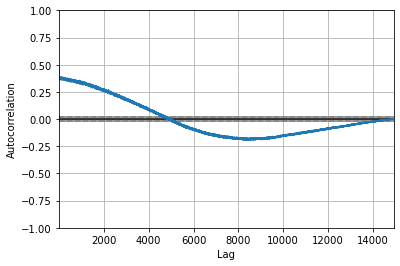

In [84]:
autocorrelation_plot(arima_product.INVOICED)
pyplot.show()

In [85]:
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA', FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA', FutureWarning)
from statsmodels.tsa.arima_model import ARIMA

arima_model = ARIMA(arima_product.INVOICED, order=(10,0,0))
model_fit = arima_model.fit(disp=0)
print(model_fit.summary())

C:\Users\cheah\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



                              ARMA Model Results                              
Dep. Variable:               INVOICED   No. Observations:                14924
Model:                    ARMA(10, 0)   Log Likelihood              -55652.169
Method:                       css-mle   S.D. of innovations             10.075
Date:                Sat, 31 Jul 2021   AIC                         111328.338
Time:                        16:23:13   BIC                         111419.667
Sample:                             0   HQIC                        111358.647
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             157.9862      0.521    303.359      0.000     156.965     159.007
ar.L1.INVOICED      0.2483      0.008     30.411      0.000       0.232       0.264
ar.L2.INVOICED      0.1068      

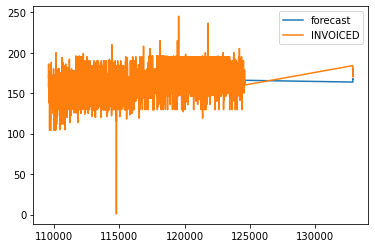

In [86]:
#Plot Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

# Baseline Model

In [87]:
def model_output(model_function, product_name, model_name):
    
    """
    Function to return actual vs predicted output graph based on input model
    Input paramters:
        model_function (type: function) : name of model + brackets
        product_name (type: string) : product of interest, i.e Gas Oil Drum etc
        model_name (type: string) : name of model in string format, i.e. 'XGBoost'
    """
    model = model_function

    # Fit the model to the training features and targets
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred,squared=False)

    # Check the score on train and test
    
    print('r^2 score on train set: {}'.format(model.score(X_train, y_train)))
    print('r^2 score on test set: {}'.format(model.score(X_test,y_test)))
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    
    y_test_series = pd.Series(y_test, name='y_test').reset_index()
    y_pred_series = pd.Series(y_pred, name='y_pred').reset_index()
    df_test_visuals_descr = df_test_visuals['DESCRIPTION'].reset_index()
    df_test_visuals_id = df_test_visuals['INVOICE_DATE'].reset_index()
    
    df_forecast = pd.concat([df_test_visuals_descr, df_test_visuals_id, y_test_series, y_pred_series], axis=1)
    
    df_forecast = df_forecast[['DESCRIPTION', 'INVOICE_DATE', 'y_test', 'y_pred']] 
    df_forecast_bp = df_forecast[df_forecast.DESCRIPTION==product_name]
    df_forecast_bp_ap = df_forecast_bp[['INVOICE_DATE', 'y_test', 'y_pred']]
    
    #Pickle the model
    model_name = model_name + '.pkl'
    pickle.dump(model, open(model_name,'wb'))
    
    cols = X_train.columns.tolist()
    with open('col_format', 'wb') as fp:
        pickle.dump(cols, fp)
    
    #Model Performance 7 days analysis
    plt.figure(figsize = (25, 8))
    sns.lineplot(x=df_forecast_bp_ap.INVOICE_DATE, y='y_test', data=df_forecast_bp_ap)

    sns.lineplot(x=df_forecast_bp_ap.INVOICE_DATE, y='y_pred', data=df_forecast_bp_ap)

    plt.xticks(fontsize='large')
    plt.yticks(fontsize='large')
    plt.title('Actual vs Predictions', fontsize=15)

    plt.legend(labels=["Actual","Prediction"])
    
    return plt.show()

r^2 score on train set: 0.9650093550576624
r^2 score on test set: 0.9566408552340668
Mean Absolute Error: 10.4039019988054
Mean Squared Error: 470.89350177646884
Root Mean Squared Error: 21.700080685943746


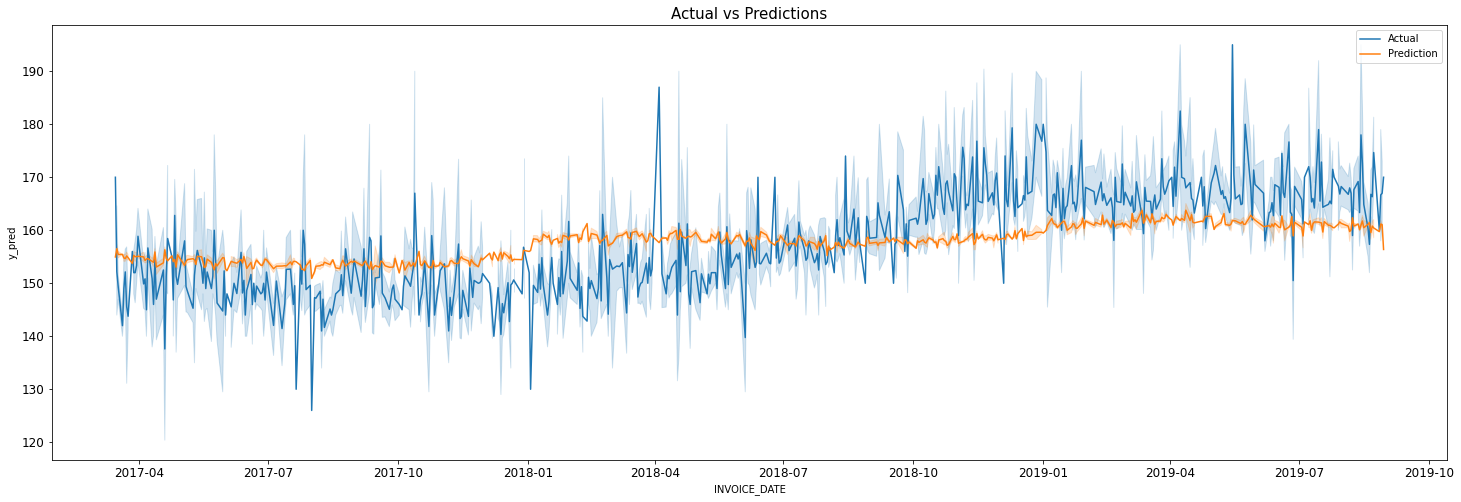

In [88]:
model_output(LinearRegression(), 'Gas Oil 200L Drum  - UN No 1202 Class 3 (III) (D/E)', 'LR')

r^2 score on train set: 0.9650093550576624
r^2 score on test set: 0.9566408552340668
Mean Absolute Error: 10.4039019988054
Mean Squared Error: 470.89350177646884
Root Mean Squared Error: 21.700080685943746


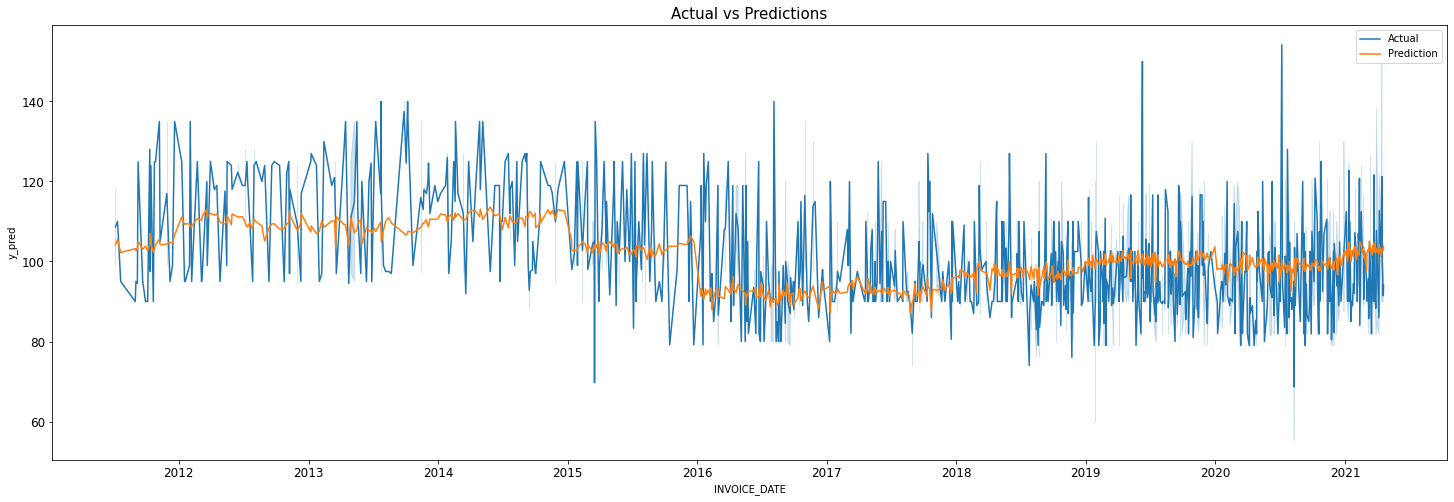

In [89]:
model_output(LinearRegression(), 'AdBlue 205L', 'LR')

## Random Forest, XGB, Gradient Boosting & Decision Tree Regressor models

r^2 score on train set: 0.9791702048255193
r^2 score on test set: 0.9620390778150102
Mean Absolute Error: 8.633271039907111
Mean Squared Error: 412.26716243717374
Root Mean Squared Error: 20.304363137935987


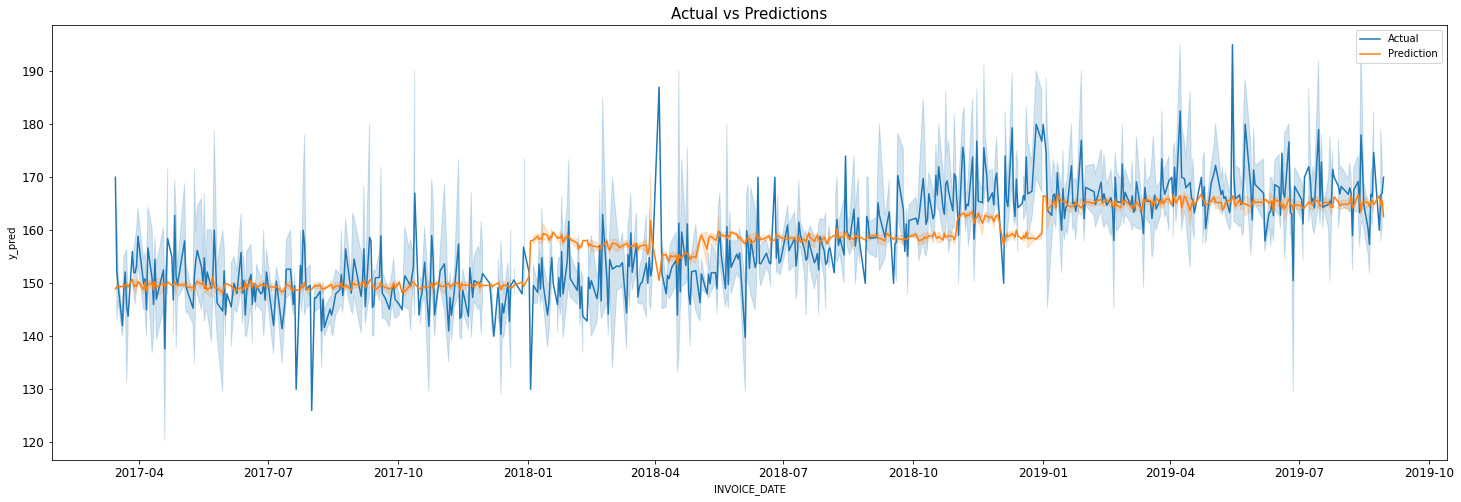

In [90]:
model_output(XGBRegressor(random_state = 42), 'Gas Oil 200L Drum  - UN No 1202 Class 3 (III) (D/E)', 'xgboost')

r^2 score on train set: 0.9791702048255193
r^2 score on test set: 0.9620390778150102
Mean Absolute Error: 8.633271039907111
Mean Squared Error: 412.26716243717374
Root Mean Squared Error: 20.304363137935987


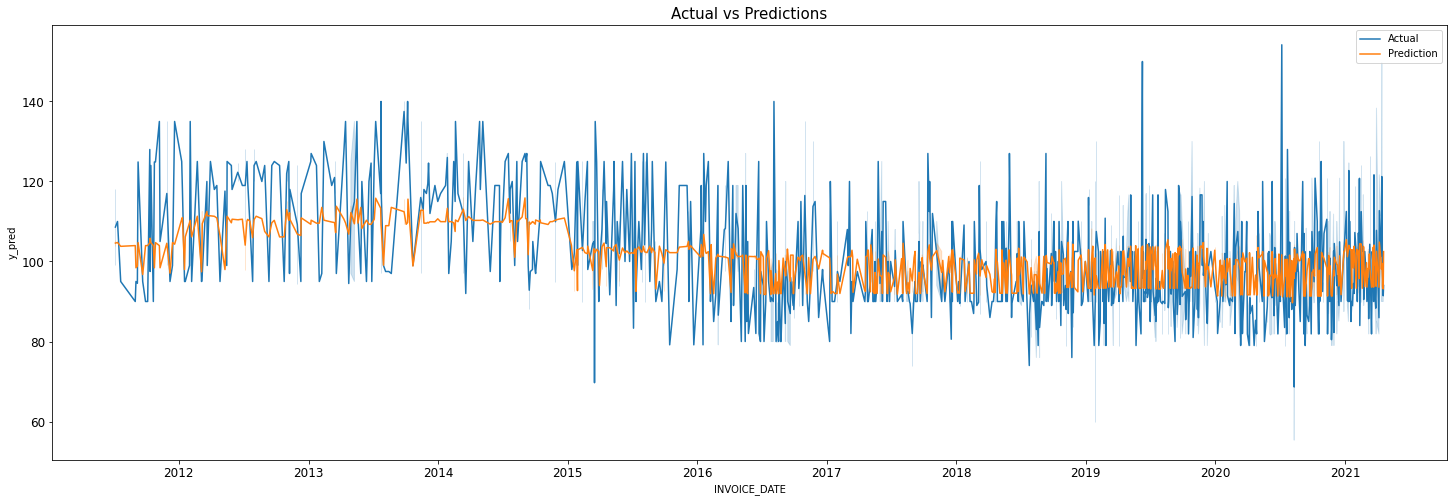

In [91]:
model_output(XGBRegressor(random_state = 42), 'AdBlue 205L', 'xgboost')

r^2 score on train set: 0.9936751944891193
r^2 score on test set: 0.9620386761744687
Mean Absolute Error: 7.849861572374838
Mean Squared Error: 412.2715243756319
Root Mean Squared Error: 20.304470551472942


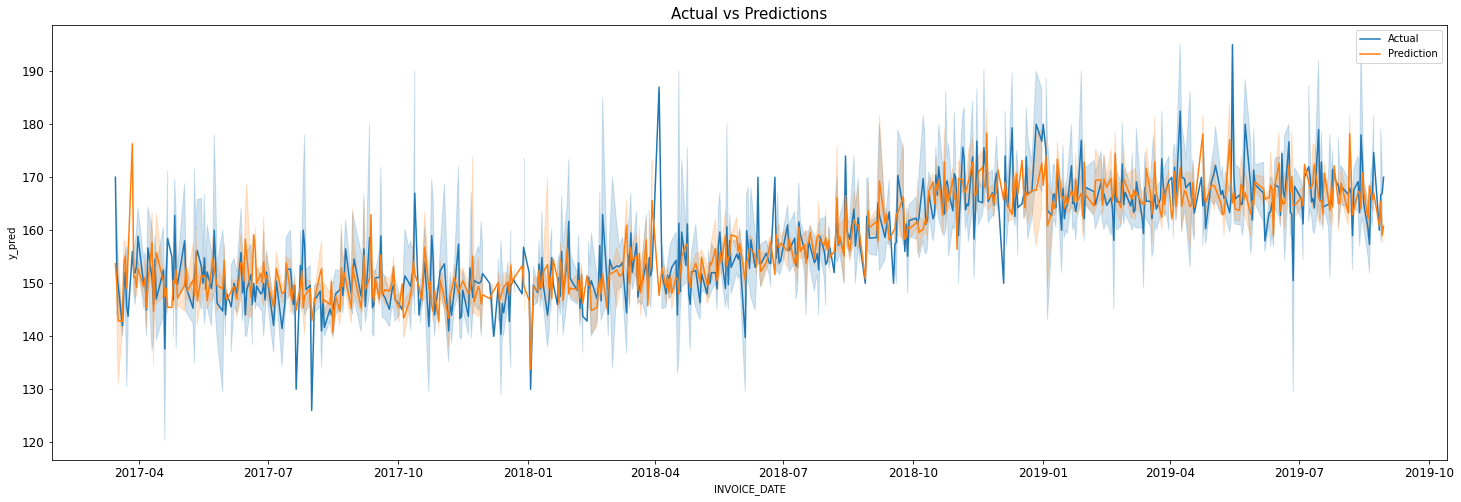

In [92]:
model_output(RandomForestRegressor(random_state = 42), 'Gas Oil 200L Drum  - UN No 1202 Class 3 (III) (D/E)', 'randomforest')

r^2 score on train set: 0.9936751944891193
r^2 score on test set: 0.9620386761744687
Mean Absolute Error: 7.849861572374838
Mean Squared Error: 412.2715243756319
Root Mean Squared Error: 20.304470551472942


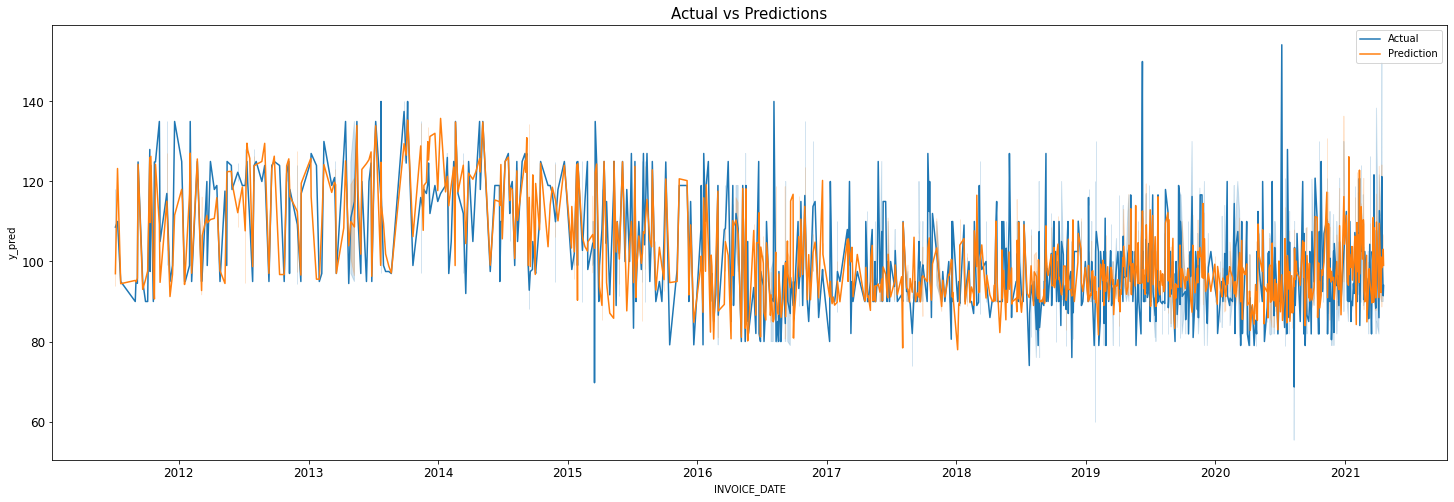

In [93]:
model_output(RandomForestRegressor(random_state = 42), 'AdBlue 205L', 'randomforest')

r^2 score on train set: 0.9619717631131665
r^2 score on test set: 0.9524596762103065
Mean Absolute Error: 11.182051476096913
Mean Squared Error: 516.3023778666583
Root Mean Squared Error: 22.722288130086245


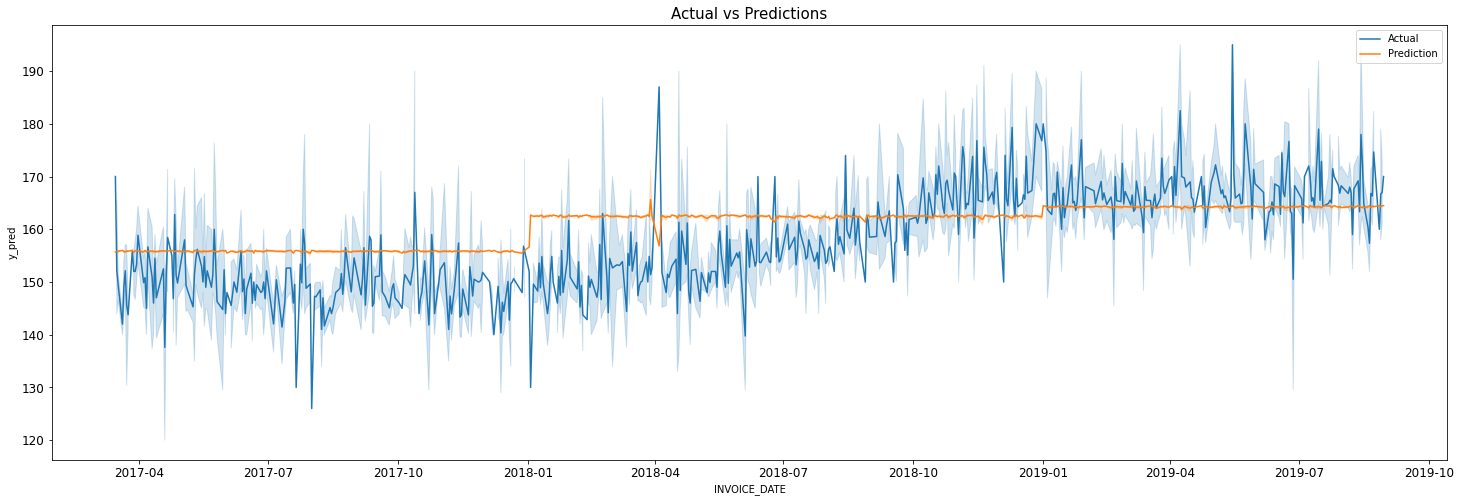

In [94]:
model_output(GradientBoostingRegressor(random_state = 42), 'Gas Oil 200L Drum  - UN No 1202 Class 3 (III) (D/E)', 'gbr')

r^2 score on train set: 0.9619717631131665
r^2 score on test set: 0.9524596762103065
Mean Absolute Error: 11.182051476096913
Mean Squared Error: 516.3023778666583
Root Mean Squared Error: 22.722288130086245


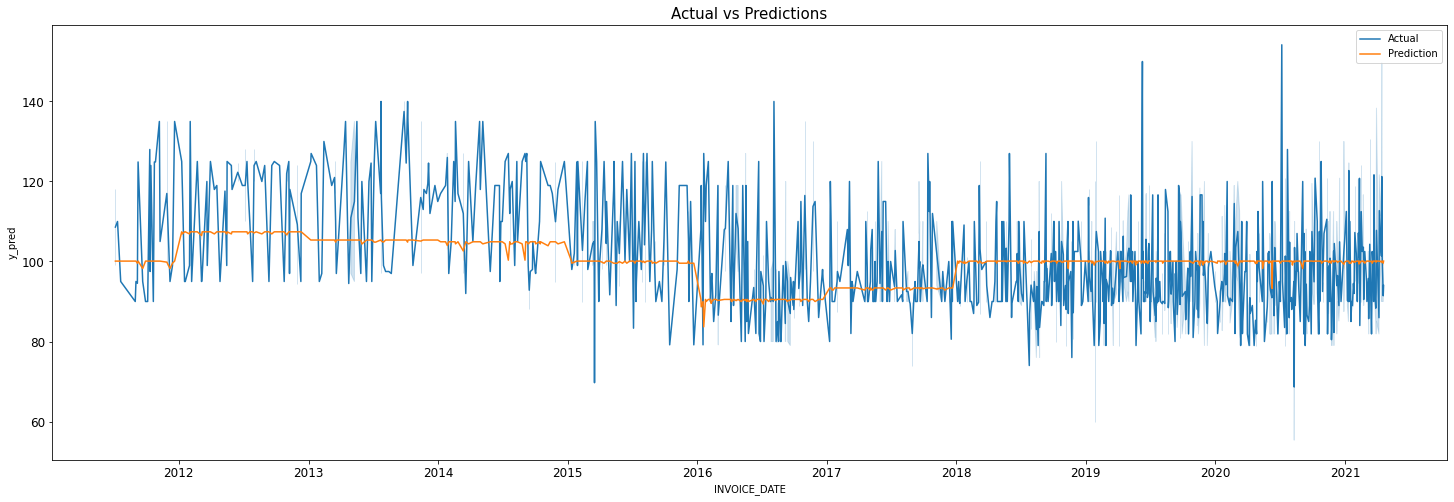

In [95]:
model_output(GradientBoostingRegressor(random_state = 42), 'AdBlue 205L', 'gbr')

r^2 score on train set: 0.9970973493287045
r^2 score on test set: 0.934535146261395
Mean Absolute Error: 9.026353479995528
Mean Squared Error: 710.9682256573594
Root Mean Squared Error: 26.663987429815506


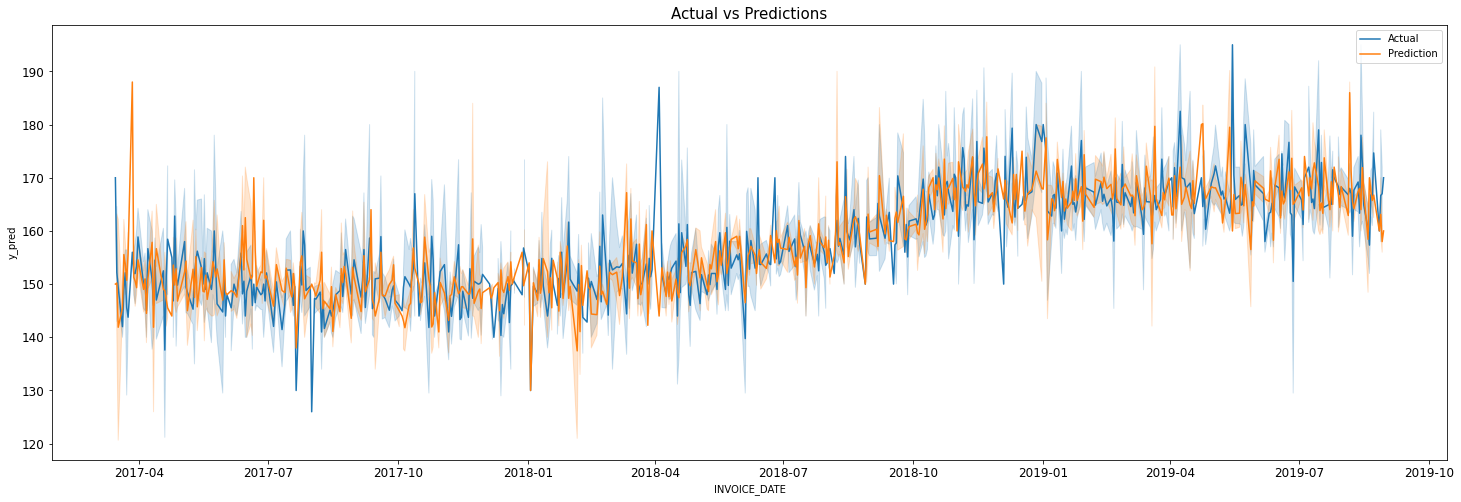

In [96]:
model_output(DecisionTreeRegressor(random_state = 42), 'Gas Oil 200L Drum  - UN No 1202 Class 3 (III) (D/E)', 'decisiontree')

r^2 score on train set: 0.9970973493287045
r^2 score on test set: 0.934535146261395
Mean Absolute Error: 9.026353479995528
Mean Squared Error: 710.9682256573594
Root Mean Squared Error: 26.663987429815506


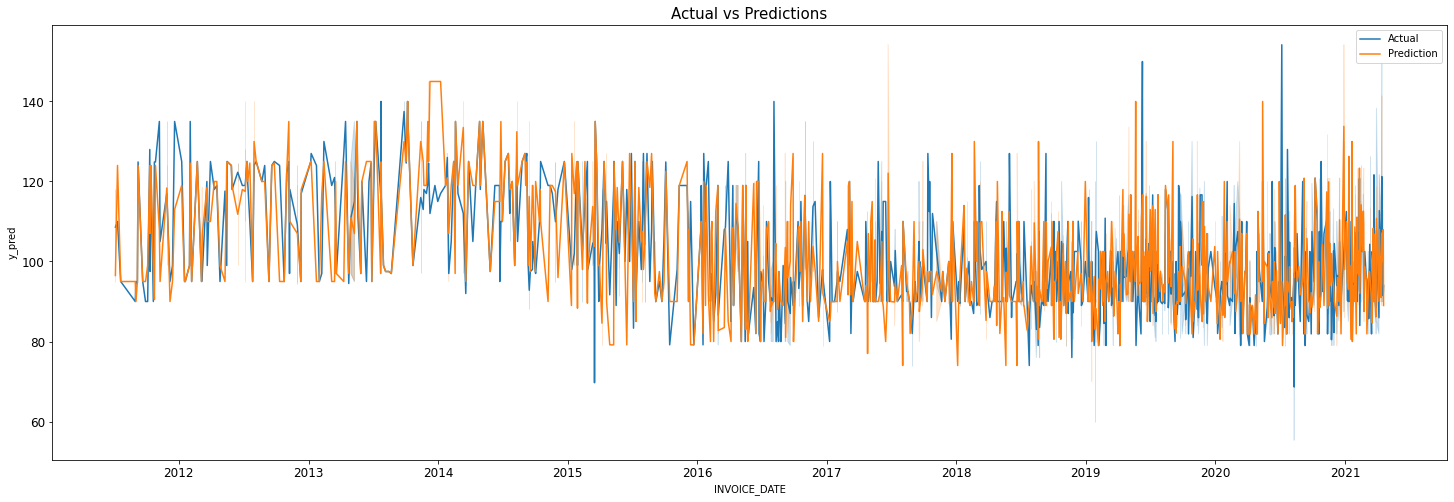

In [97]:
model_output(DecisionTreeRegressor(random_state = 42), 'AdBlue 205L', 'decisiontree')

# Best Models 

In [100]:
from sklearn.ensemble import RandomForestRegressor
# Create a Random Forest regression model with default arguments for fine-tuning purposes
model_rf = RandomForestRegressor(random_state=42)

# Fit the model to the training features 
model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)



In [101]:
model_xgb = XGBRegressor(random_state=42)

# Create a XGB regression model with default arguments for fine-tuning purposes
model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_test)



# Fine-tune Random Forest using Randomized Search CV

In [102]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 45, num = 3)]
# Minimum number of samples required to split a node
min_samples_split = [5, 10]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}

print(random_grid)

{'n_estimators': [20, 65, 110, 155, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [1, 23, 45], 'min_samples_split': [5, 10]}


In [103]:
# Use the random grid to search for best hyperparameters. We use this to reduce the number of iterations. 
#RandomizedSearchCV helps by selecting combinations at random to a sample of wide range values

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = model_rf, param_distributions = random_grid, n_iter = 10, cv = 10, verbose=2, random_state=42, n_jobs = -1, scoring='neg_mean_squared_error')
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [1, 23, 45],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [5, 10],
                                        'n_estimators': [20, 65, 110, 155,
                                                         200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [104]:
#now let's how the RMSE changes for each parameter configuration
cvres2 = rf_random.cv_results_
for mean_score, params in zip(cvres2["mean_test_score"], cvres2["params"]):
    print(np.sqrt(-mean_score), params)

60.78926681625558 {'n_estimators': 20, 'min_samples_split': 5, 'max_features': 'auto', 'max_depth': 1}
60.78926681625558 {'n_estimators': 20, 'min_samples_split': 10, 'max_features': 'auto', 'max_depth': 1}
39.3527491754158 {'n_estimators': 65, 'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 23}
18.342685984960955 {'n_estimators': 20, 'min_samples_split': 10, 'max_features': 'auto', 'max_depth': 45}
98.3706717947687 {'n_estimators': 155, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 1}
22.24362398217645 {'n_estimators': 200, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 45}
40.40222031739753 {'n_estimators': 155, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 23}
18.142693287826688 {'n_estimators': 155, 'min_samples_split': 10, 'max_features': 'auto', 'max_depth': 45}
98.46038843144609 {'n_estimators': 110, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 1}
22.646580820059977 {'n_estimators': 110, 'min_samples_split

In [105]:
rf_random.best_estimator_

RandomForestRegressor(max_depth=45, min_samples_split=10, n_estimators=155,
                      random_state=42)

In [106]:
rf_random.best_params_

{'n_estimators': 155,
 'min_samples_split': 10,
 'max_features': 'auto',
 'max_depth': 45}

In [107]:
rf_model = RandomForestRegressor(max_depth=45, min_samples_split=10, n_estimators=155, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=45, min_samples_split=10, n_estimators=155,
                      random_state=42)

In [108]:
# Performance metrics (MAPE)
#random_best= rf_random.best_estimator_.predict(X_train)
random_best = rf_model.predict(X_train)
pickle.dump(rf_model, open('random_forest.pkl', 'wb'))
errors = abs(random_best - y_train)
# Calculate mean absolute percentage error (MAPE)
mape = np.mean(100 * (errors / y_train))
# Calculate and display accuracy
accuracy = 100 - mape    
#print result
print('The best model from the randomized search has an accuracy of', round(accuracy, 2),'%')

The best model from the randomized search has an accuracy of 90.38 %


In [109]:
#this is the RMSE
final_mse = mean_squared_error(y_train, random_best)
final_rmse = np.sqrt(final_mse)
print('The best model from the randomized search has a RMSE of', round(final_rmse, 2))

The best model from the randomized search has a RMSE of 12.34


In [110]:
final_mae = mean_absolute_error(y_train, random_best)
print('The best model from the randomized search has a MAE of', round(final_mae, 2))

The best model from the randomized search has a MAE of 5.1


# Evaluate Random Forest Regressor model on test set

In [111]:
#final_model = rf_random.best_estimator_
# Predicting test set results
final_pred = rf_model.predict(X_test)
final_mse = mean_squared_error(y_test, final_pred)
final_rmse = np.sqrt(final_mse)
print('The final RMSE on the test set is', round(final_rmse, 2))

The final RMSE on the test set is 20.03


In [112]:
# Predicting test set results
final_pred = rf_model.predict(X_test)
final_mae = mean_absolute_error(y_test, final_pred)
print('The final MAE on the test set is', round(final_mae, 2))

The final MAE on the test set is 7.81


In [113]:
#calculate accuracy
errors = abs(final_pred - y_test)
# Calculate mean absolute percentage error (MAPE)
mape = np.mean(100 * (errors / y_test))
# Calculate and display accuracy
accuracy = 100 - mape    
#print result
print('The best model achieves on the test set an accuracy of', round(accuracy, 2),'%')

The best model achieves on the test set an accuracy of 87.22 %


# Fine-tune XGB Regressor using Grid Search CV

In [114]:
xgb_grid = XGBRegressor(random_state=42)
model_trial = xgb_grid.fit(X_train, y_train)
y_pred = model_trial.predict(X_test)

In [115]:
model_trial.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 4,
 'num_parallel_tree': 1,
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [116]:
params = {'min_child_weight':[4,5], 
          'gamma':[i/10.0 for i in range(3,6)], 
          'subsample':[i/10.0 for i in range(6,11)],
          'colsample_bytree':[i/10.0 for i in range(6,11)], 
          'max_depth': [2,3,4],
          'objective': ['reg:squarederror'],
          'random_state': [42]
         }

best_xgb = GridSearchCV(xgb_grid,
                        params,
                        cv = 2,
                        n_jobs = 1,
                        verbose=True)

best_xgb.fit(X_train,
         y_train)


print(best_xgb.best_params_)

Fitting 2 folds for each of 450 candidates, totalling 900 fits
{'colsample_bytree': 0.8, 'gamma': 0.3, 'max_depth': 4, 'min_child_weight': 5, 'objective': 'reg:squarederror', 'random_state': 42, 'subsample': 1.0}


In [117]:
best_xgb.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0.3, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [118]:
best_xgb.best_params_

{'colsample_bytree': 0.8,
 'gamma': 0.3,
 'max_depth': 4,
 'min_child_weight': 5,
 'objective': 'reg:squarederror',
 'random_state': 42,
 'subsample': 1.0}

In [119]:
# Performance metrics (MAPE)
xgb_best= best_xgb.best_estimator_.predict(X_train)
errors = abs(xgb_best - y_train)
# Calculate mean absolute percentage error (MAPE)
mape = np.mean(100 * (errors / y_train))
# Calculate and display accuracy
accuracy = 100 - mape    
#print result
print('The best model from grid search has an accuracy of', round(accuracy, 2),'%')

The best model from grid search has an accuracy of 63.83 %


In [120]:
#this is the RMSE
final_mse = mean_squared_error(y_train, xgb_best)
final_rmse = np.sqrt(final_mse)
print('The best model from the grid search has a RMSE of', round(final_rmse, 2))

The best model from the grid search has a RMSE of 17.83


In [121]:
final_mae = mean_absolute_error(y_train, xgb_best)
print('The best model from the grid search has a MAE of', round(final_mae, 2))

The best model from the grid search has a MAE of 9.32


# Evaluate XGB Regressor model on test set

In [122]:
final_model_2 = best_xgb.best_estimator_
# Predicting test set results
final_pred = final_model_2.predict(X_test)
final_mse = mean_squared_error(y_test, final_pred)
final_rmse = np.sqrt(final_mse)
print('The final RMSE on the test set is', round(final_rmse, 2))

The final RMSE on the test set is 21.19


In [123]:
final_model_2 = best_xgb.best_estimator_
# Predicting test set results
final_pred = final_model_2.predict(X_test)
final_mae = mean_absolute_error(y_test, final_pred)
print('The final MAE on the test set is', round(final_mae, 2))

The final MAE on the test set is 9.72


# Feature Importance

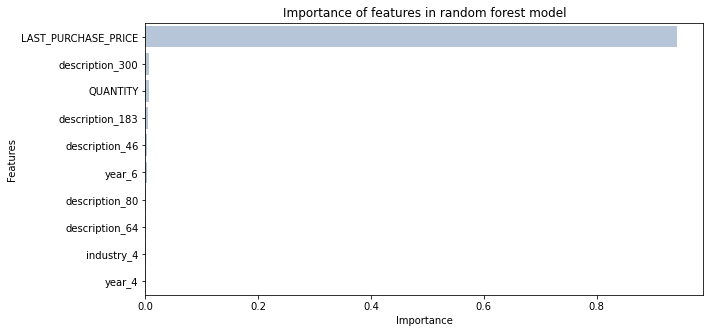

In [125]:
#see the importance of the attributes
rf_fi = pd.DataFrame(rf_model.feature_importances_)
rf_fi=rf_fi.T
rf_fi.columns = pd.DataFrame(X_train).columns
rf_fi=rf_fi.T
rf_fi.columns =['importance']
rf_fi=rf_fi.sort_values(by="importance", ascending=False)[:10]

#visualize importance
plt.figure(figsize=(10,5))
p1=sns.barplot(x="importance", y=rf_fi.index, data=rf_fi, ci=None, color='lightsteelblue')
p1.set(xlabel='Importance',ylabel='Features',title='Importance of features in random forest model')
plt.show()

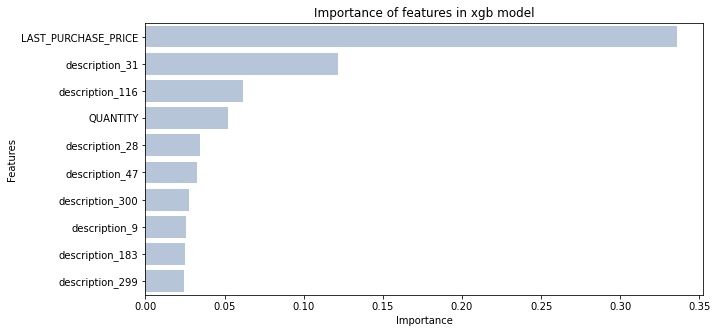

In [128]:
#see the importance of the attributes
xgb_fi = pd.DataFrame(final_model_2.feature_importances_)
xgb_fi=xgb_fi.T
xgb_fi.columns = pd.DataFrame(X_train).columns
xgb_fi=xgb_fi.T
xgb_fi.columns =['importance']
xgb_fi=xgb_fi.sort_values(by="importance", ascending=False)[:10]

#visualize importance
plt.figure(figsize=(10,5))
p1=sns.barplot(x="importance", y=xgb_fi.index, data=xgb_fi, ci=None, color='lightsteelblue')
p1.set(xlabel='Importance',ylabel='Features',title='Importance of features in xgb model')
plt.show()

# Online Lubricant Model Demonstration

In [127]:
def predict_price(product_name, lpp, industry, quantity):
    
    """
    Price prediction function using RandomForestRegressor model + industry average.
    Input paramters:
        product_name (type: string): name of product
        lpp (type:float): last purchase price of product
        industry(type:string): Industry of purchasing company
        quantity(type:float): Quantity
        
    """
    description_mapping = pd.read_csv('description_mapping.csv', names=['mapping', 'value'])
    industry_mapping = pd.read_csv('industry_mapping.csv', names=['mapping', 'value'])
    date = pd.to_datetime("today")
    day = 'day_' + str(date.day)
    month = 'month_' + str(date.month)
    
    product_mapped = description_mapping[description_mapping.value==str(product_name)]['mapping'].values[0]
    industry_mapped = industry_mapping[industry_mapping.value==str(industry)]['mapping'].values[0]
    
    with open ('col_format', 'rb') as fp:
        cols = pickle.load(fp)
    
    tmp_df = pd.DataFrame(np.zeros((1, 378)), columns=cols)
    tmp_df['QUANTITY'] = float(quantity)
    tmp_df['LAST_PURCHASE_PRICE'] = float(lpp)
    tmp_df[product_mapped] = 1
    tmp_df[industry_mapped] = 1
    tmp_df[day] = 1
    tmp_df[month] = 1
    
    
    randomforest = pickle.load(open('random_forest.pkl', 'rb'))
    
    y_pred = randomforest.predict(tmp_df)[0]
    
    #Industry average
    
    industry_averages = pd.read_csv('industry_average.csv', usecols=['INVOICE_DATE', 'DESCRIPTION', 'category_name', 'INVOICED', 'moving_average_30', 'moving_average_7'])
    current_avg = industry_averages[(industry_averages.DESCRIPTION == str(product_name)) & (industry_averages.category_name==str(industry))].sort_values('INVOICE_DATE').tail(1)['moving_average_7'].values[0]

    predicted_price = (current_avg + y_pred)/2
    
    return predicted_price

In [129]:
#Final outcome test
print('Input product: ')
product_name = input()
print('Input industry: ')
industry = input()
print('Input last purchase price: ')
lpp = input()
print('Input quantity purchasing: ')
quantity = input()

predicted_price = predict_price(product_name, float(lpp), industry, float(quantity))
print("Your predicted price is: "+str(round(predicted_price,2)))


Input product: 
Gas Oil 200L Drum  - UN No 1202 Class 3 (III) (D/E)
Input industry: 
Construction
Input last purchase price: 
129
Input quantity purchasing: 
1
Your predicted price is: 160.92
